In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
from collections import defaultdict
import sys
sys.path.append("../plenoxels")
# from plenoxels.simple_tree import init_render_opt, VolumeRenderFunction, Octree
from tc_plenoptimize import init_datasets, init_profiler, parse_config, init_sh_encoder
import config
import matplotlib.pyplot as plt
import math
import matplotlib
import time
# from nerf_sr import (init_multi_dset, init_plenoxels, init_sr, init_multi_dset_v2,
#                     run_tree_epoch, run_sr_epoch, run_joint_epoch)
# from plenoxels.corner_tree import CornerTree, CornerTreeRenderFn, QuantizedCornerTree
from vq import VectorQuantizerEMA

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [4]:
cfg = config.get_cfg_defaults()
dev = "cuda"

In [5]:
def plot_ts(ts_dset, tree, use_ext, batch_size=10_000):
    with torch.autograd.no_grad():
        for ts_el in ts_dset:
            if len(ts_el) == 3:
                rays_o, rays_d, rgb = ts_el
                img_h, img_w = ts_dset.img_h, ts_dset.img_w
            else:
                rays, rgb, _, _ = ts_el
                img_h, img_w = ts_dset.low_resolution, ts_dset.low_resolution
            preds = []
            for b in range(math.ceil(rays_o.shape[0] / batch_size)):
                rays_o_b = rays_o[b * batch_size: (b + 1) * batch_size].to("cuda")
                rays_d_b = rays_d[b * batch_size: (b + 1) * batch_size].to("cuda")
                preds.append(tree(rays_o_b, rays_d_b, use_ext).cpu())
            pred = torch.cat(preds, 0).view(img_h, img_w, 3)
            rgb = rgb.view(img_h, img_w, 3)
            mse = torch.mean((pred - rgb) ** 2)
            psnr = -10.0 * torch.log(mse) / math.log(10)
            break
    fig, ax = plt.subplots(ncols=2)
    ax[0].imshow(pred)
    ax[1].imshow(rgb)
    ax[0].set_title(f"PSNR={psnr:.2f}")
    
def plot_ts_sr(ts_dset, trees, sr, model_fw, plot_idx=0):
    with torch.autograd.no_grad():
        ts_el = ts_dset[plot_idx]
        if isinstance(ts_el, dict):
            rays, rgb, rgb_hr, scene_id = ts_el['rays'], ts_el['low'], ts_el['high'], ts_el['scene_id']
        else:
            rays, rgb, rgb_hr, scene_id = ts_el
        tree = trees[scene_id]

        preds_lr, preds_hr = model_fw(tree, sr, rays, ts_dset)
        preds_lr = preds_lr.reshape(ts_dset.low_resolution, ts_dset.low_resolution, 3).cpu()
        preds_hr = preds_hr.reshape(ts_dset.high_resolution, ts_dset.high_resolution, 3).cpu()

        rgb = rgb.view(ts_dset.low_resolution, ts_dset.low_resolution, 3)
        rgb_hr = rgb_hr.view(ts_dset.high_resolution, ts_dset.high_resolution, 3)

        mse_lr = torch.mean((preds_lr - rgb) ** 2)
        psnr_lr = -10.0 * torch.log(mse_lr) / math.log(10)
        mse_hr = torch.mean((preds_hr - rgb_hr) ** 2)
        psnr_hr = -10.0 * torch.log(mse_hr) / math.log(10)
    fig, ax = plt.subplots(ncols=2)
    ax[0].imshow(preds_lr)
    ax[0].set_title(f"PSNR={psnr_lr:.2f}")
    ax[1].imshow(preds_hr)
    ax[1].set_title(f"PSNR={psnr_hr:.2f}")

Use cubeviz as
```cubeviz(40, tree, view_thresh=20)```

In [6]:
def cubeviz(num_pts, tree, alpha=0.5, transparent_thresh=None, view_thresh=None):
    x = np.linspace(0, 1, num_pts)
    y = np.linspace(0, 1, num_pts)
    z = np.linspace(0, 1, num_pts)
    coo = np.stack([m.ravel() for m in np.meshgrid(x, y, z)], axis=1)
    C = tree.query(torch.from_numpy(coo).to(dtype=torch.float32, device=tree.child.device),
                   normalize=False)[0][:, -1]
    C = C.cpu().detach().numpy()
    
    C = C.reshape(len(x), len(y), len(z))
    coo = coo.reshape(len(x), len(y), len(z), -1).transpose(3, 0, 1, 2)
    minn, maxx = C.min(), C.max()
    norm = matplotlib.colors.Normalize(minn, maxx)
    m = plt.cm.ScalarMappable(norm=norm, cmap='jet')
    m.set_array([])
    Cr = C.ravel()
    transparency = np.ones(Cr.shape[0]) * alpha
    if transparent_thresh is not None:
        transparency[Cr < transparent_thresh] = 0.0
    fcolors = m.to_rgba(Cr, alpha=transparency)

    fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
    if view_thresh is None:
        voxels = C >= minn
    else:
        voxels = C >= view_thresh
    ax.voxels(voxels,
              facecolors=fcolors.reshape(C.shape[0], C.shape[1], C.shape[2], -1));

### Invocation sample for old octree

In [7]:
tree = Octree(max_internal_nodes=1, initial_levels=1, 
              sh_degree=2, render_opt=init_render_opt(),
              branching=2,
              radius=(tr_dset.scene_bbox[1] - tr_dset.scene_bbox[0]) / 2,
              center=(tr_dset.scene_bbox[1] + tr_dset.scene_bbox[0]) / 2,
              parent_sum=True, dtype=torch.float32).cuda()
with torch.autograd.no_grad():
    tree.data[..., :-1].fill_(0.005)  # RGB
    tree.data[..., -1].fill_(0.05)    # Density

NameError: name 'Octree' is not defined

## Corner Tree

Initialize like:
```
t = CornerTree(sh_degree=1, init_internal=585, 
               aabb=torch.tensor([[-1.3, -1.3, -1.3], [1.3, 1.3, 1.3]]), near=2., far=6.,
               init_rgb=0.01, init_sigma=0.1)
t.refine()
t.refine()
t.refine()
t.refine()
```

In [6]:
_corner_tree_max_side = 256
def enc_pos(coo):
    return (coo[:, 0] * (_corner_tree_max_side ** 3) + 
            coo[:, 1] * (_corner_tree_max_side ** 2) + 
            coo[:, 2] * _corner_tree_max_side).long()

In [126]:
from plenoxels.tc_plenoxel import plenoxel_sh_encoder


class CornerTree(torch.nn.Module):
    def __init__(self, 
                 sh_degree: int,
                 init_internal: int, 
                 aabb: torch.Tensor, 
                 near: float, 
                 far: float,
                 init_rgb: float,
                 init_sigma: float):
        super().__init__()
        self.data_dim = 3 * (sh_degree + 1) ** 2 + 1
        # TODO: near and far should be transformed
        self.near = near
        self.far = far
        # 1 / diameter
        scaling = 1 / (aabb[1] - aabb[0])
        # 0.5 - center / diameter
        offset = 0.5 - 0.5 * (aabb[0] + aabb[1]) * scaling
        self.num_samples = 128
        self.white_bkgd = True
        self.init_rgb = init_rgb
        self.init_sigma = init_sigma
        self.sh_encoder = plenoxel_sh_encoder(sh_degree)
        
        child    = torch.empty(init_internal, 2, 2, 2, dtype=torch.long)
        coords   = torch.empty(init_internal, 2, 2, 2, 3)
        nids     = torch.empty(init_internal, 2, 2, 2, 8, dtype=torch.long)
        depths   = torch.empty(init_internal, dtype=torch.long)
        is_child_leaf = torch.ones(init_internal, 2, 2, 2, dtype=torch.bool)
        self.data = torch.nn.EmbeddingBag(1, self.data_dim, mode='sum')           # n_data, data_dim
        
        offsets_3d = torch.tensor([[-1, -1, -1], [-1, -1, 1], [-1, 1, -1], [-1, 1, 1],
                                   [1, -1, -1], [1, -1, 1], [1, 1, -1], [1, 1, 1]])
        self.register_buffer("offset", offset)
        self.register_buffer("scaling", scaling)
        self.register_buffer("aabb", aabb)
        self.register_buffer("offsets_3d", offsets_3d)
        self.register_buffer("child", child)
        self.register_buffer("coords", coords)
        self.register_buffer("nids", nids)
        self.register_buffer("depths", depths)
        self.register_buffer("is_child_leaf", is_child_leaf)
        self.register_buffer("ucoo", torch.tensor([]))
        self.n_internal = 0
        
    def trasform_coords(self, coords):
        """From world-coordinates to tree-coordinates (a cube between 0 and 1)"""
        return self.offset + coords * self.scaling

    @torch.no_grad()
    def refine(self, leaves=None):
        # 1. figure out the coordinates of the leaves. This is non-trivial, likely requires traeversing the tree.
        # 2. split the leaves. Add child, is_child_leaf, parent, depth.

        # 3. For each new leaf calculate coordinates of its neighbors.
        # 4. encode neighbor coordinates, and append to existing coordinates
        # 5. Unique with inverse.
        # 6. Run whatever is below
        if leaves is None:
            leaves = self.is_child_leaf[:self.n_internal].nonzero(as_tuple=False)  # n_leaves, 4
        sel = (leaves[:, 0], leaves[:, 1], leaves[:, 2], leaves[:, 3])
        
        n_int = self.n_internal
        n_nodes = self.n_internal * 8 + 1
        n_int_new = leaves.shape[0] if n_int > 0 else 1
        n_nodes_fin = n_nodes + n_int_new * 8
        print(f"{n_int=}, {n_nodes=}, {n_int_new=}, {n_nodes_fin=}")
        if n_int_new + n_int > self.child.shape[0]:
            raise RuntimeError(f"Not enough data-space for refinement. "
                               f"Need {n_int_new + n_int}, Have {self.child.shape[0]}")

        leaf_coo = self.coords[sel] if n_int > 0 else torch.tensor([[0.5, 0.5, 0.5]])
        depths = self.depths[sel[0]] if n_int > 0 else torch.tensor([0])
        # + 1 since it's the new leaf, and +1 to get half-voxel-size
        new_leaf_sizes = (1 / (2 ** (depths + 2))).unsqueeze(-1).unsqueeze(-1)
        
        n_offsets = self.offsets_3d.unsqueeze(0).repeat(n_int_new, 1, 1) * new_leaf_sizes  # [nl, 8, 3]
        new_child = (
            torch.arange(n_nodes, n_nodes_fin, dtype=torch.int32).view(-1, 2, 2, 2)
            - torch.arange(n_int, n_int + n_int_new).view(-1, 1, 1, 1)
        )
        self.child[n_int: n_int + n_int_new] = new_child
        self.is_child_leaf[sel] = False
        
        new_leaf_coo = leaf_coo.unsqueeze(1) + n_offsets  # [nl, 8, 3]
        self.coords[n_int: n_int + n_int_new] = new_leaf_coo.view(-1, 2, 2, 2, 3)
        self.depths[n_int: n_int + n_int_new] = depths + 1
        
        self.n_internal = n_int + n_int_new
        
        # From leaf center to corners (nl -> 8*nl=nc)
        new_corners = (new_leaf_coo.view(-1, 1, 3) + n_offsets.repeat_interleave(8, dim=0)).view(-1, 3)
        new_corners_enc = enc_pos(new_corners)
        # Need to get all the encoded corner positions of the whole tree.
        if n_int > 0:
            corners_enc = torch.cat((self.ucoo[self.nids[:n_int].view(-1)], new_corners_enc))
        else:
            corners_enc = new_corners_enc
        
        new_u_cor, new_cor_idx = torch.unique(corners_enc, return_inverse=True, sorted=True)
        print(f"Deduped corner coordinates from {corners_enc.shape[0]} to {new_u_cor.shape[0]}")
        
        # Update the tree-data: create new tensor, copy the old data into it (with changed indices).
        new_data = torch.zeros(new_u_cor.shape[0], self.data_dim)
        new_data[:, :-1].fill_(self.init_rgb)
        new_data[:, -1].fill_(self.init_sigma)
        if n_int > 0:
            new_data[torch.searchsorted(new_u_cor, self.ucoo), :] = self.data.weight
        self.data = torch.nn.EmbeddingBag.from_pretrained(new_data, freeze=False, mode='sum', sparse=False)
        self.ucoo = new_u_cor
        # TODO: parent data should be copied into the corresponding children

        # New neighbor indices
        self.nids[:n_int + n_int_new] = new_cor_idx.view(-1, 2, 2, 2, 8)
        
    def query(self, indices):
        n = indices.shape[0]

        with torch.autograd.no_grad():
            indices = self.trasform_coords(indices)
            node_ids = torch.zeros(n, dtype=torch.long, device=indices.device)
            remain_indices = torch.arange(n, dtype=torch.long, device=indices.device)
            floor_indices = torch.zeros(n, 3, dtype=torch.float, device=indices.device)
            xy = indices
            while remain_indices.numel():
                xy *= 2
                floor = torch.floor(xy)
                floor.clamp_max_(1)
                xy -= floor
                sel = (node_ids[remain_indices], *(floor.long().T),)
                deltas = self.child[sel]

                term_mask = self.is_child_leaf[sel]  # terminate when nodes with 0 children encountered (leaves).
                term_indices = remain_indices[term_mask]

                indices.scatter_(0, term_indices.unsqueeze(-1).repeat(1, 3), xy[term_mask])
                floor_indices.scatter_(0, term_indices.unsqueeze(-1).repeat(1, 3), floor[term_mask])
                
                remain_indices = remain_indices[~term_mask]
                if not remain_indices.numel():
                    break
                
                node_ids[remain_indices] += deltas
                xy = xy[~term_mask]
                floor = floor[~term_mask]

        xy = indices
        sel = (node_ids, *(floor_indices.long().T),)
        sel_nids = self.nids[sel]  # n, 8
        weights = torch.stack((
            (1 - xy[:, 0]) * (1 - xy[:, 1]) * (1 - xy[:, 2]),
            (1 - xy[:, 0]) * (1 - xy[:, 1]) * (xy[:, 2]),
            (1 - xy[:, 0]) * (xy[:, 1])     * (1 - xy[:, 2]),
            (1 - xy[:, 0]) * (xy[:, 1])     * (xy[:, 2]),
            (xy[:, 0])     * (1 - xy[:, 1]) * (1 - xy[:, 2]),
            (xy[:, 0])     * (1 - xy[:, 1]) * (xy[:, 2]),
            (xy[:, 0])     * (xy[:, 1])     * (1 - xy[:, 2]),
            (xy[:, 0])     * (xy[:, 1])     * (xy[:, 2]),
        ), dim=1)  # n, 8
        return self.data(sel_nids, per_sample_weights=weights)
    
    @torch.no_grad()
    def sample_proposal(self, rays_o, rays_d, max_samples):
#         rays_o = self.trasform_coords(rays_o)
        # scale direction
        rays_d.mul_(self.scaling)
        delta_scale = 1 / torch.linalg.norm(rays_d, dim=1, keepdim=True)
        rays_d.mul_(delta_scale)
        step_size = 1 / max_samples
        
        offsets_pos = (self.aabb[1] - rays_o) / rays_d  # [batch, 3]
        offsets_neg = (self.aabb[0] - rays_o) / rays_d  # [batch, 3]
        offsets_in = torch.minimum(offsets_pos, offsets_neg)  # [batch, 3]
        start = torch.amax(offsets_in, dim=-1, keepdim=True)  # [batch, 1]
#         start.clamp_(min=self.near, max=self.far)  # [batch, 1]
        steps = torch.arange(max_samples, dtype=torch.float32, device=self.child.device).unsqueeze(0)  # [1, n_intrs]
        steps = steps.repeat(rays_d.shape[0], 1)   # [batch, n_intrs]
        intersections = start + steps * step_size  # [batch, n_intrs]
        dts = torch.diff(intersections, n=1, dim=1).mul(delta_scale)
        intersections = intersections[:, :-1]
        points = rays_o.unsqueeze(1) + intersections.unsqueeze(2) * rays_d.unsqueeze(1)
        points_valid = ((points > self.aabb[0]) & (points < self.aabb[1])).all(-1)
        return points, dts, points_valid
    
    def forward(self, rays_o, rays_d):
        # NOTE: sample_proposal modifies rays_d.
        pts, dt, valid = self.sample_proposal(rays_o, rays_d, self.num_samples)
        batch, nintrs = pts.shape[:2]
        
        interp_masked = self.query(pts[valid].view(-1, 3))
        interp = torch.zeros(batch, nintrs, self.data_dim, 
                             dtype=torch.float32, device=interp_masked.device)
        interp.masked_scatter_(valid.unsqueeze(-1), interp_masked)
        
        sh_mult = self.sh_encoder(rays_d)  # [batch, ch/3]
        sh_mult = sh_mult.unsqueeze(1).expand(batch, nintrs, -1).unsqueeze(2)  # [batch, nintrs, 1, ch/3]
        interp_rgb = interp[..., :-1].view(batch, nintrs, 3, sh_mult.shape[-1])  # [batch, nintrs, 3, ch/3]
        rgb = torch.sum(sh_mult * interp_rgb, dim=-1)  # [batch, nintrs, 3]
        
        sigma = interp[..., -1]  # [batch, n_intrs-1, 1]
        
        # Volumetric rendering
        alpha = 1 - torch.exp(-torch.relu(sigma) * dt)            # alpha: [batch, n_intrs-1]
        cum_light = torch.cat((torch.ones(rgb.shape[0], 1, dtype=rgb.dtype, device=rgb.device),
                               torch.cumprod(1 - alpha[:, :-1] + 1e-10, dim=-1)), dim=-1)  # [batch, n_intrs-1]
        abs_light = alpha * cum_light  # [batch, n_intersections - 1]
        acc_map = abs_light.sum(-1)    # [batch]

        # Accumulated color over the samples, ignoring background
        rgb = torch.sigmoid(rgb)  # [batch, n_intrs-1, 3]
        rgb_map = (abs_light.unsqueeze(-1) * rgb).sum(dim=-2)  # [batch, 3]

        if self.white_bkgd:
            # Including the white background in the final color
            rgb_map = rgb_map + (1. - acc_map.unsqueeze(1))

        return rgb_map

## Test Learning

In [101]:
cfg.optim.batch_size = 4000
cfg.data.max_tr_frames = None
cfg.data.max_ts_frames = 10
cfg.data.datadir = "/home/giacomo/plenoxels/data/lego"
cfg.data.downsample = 1

In [102]:
tr_dset, tr_loader, ts_dset = init_datasets(cfg, dev)

Loading test data: 100%|██████████| 10/10 [00:00<00:00, 19.38it/s]


In [103]:
data_iter = iter(tr_loader)

In [112]:
tree = CornerTree(sh_degree=2, init_internal=299593, 
                  aabb=tr_dset.scene_bbox, near=2., far=6.,
                  init_rgb=0.01, init_sigma=0.1)
tree.refine()
tree.refine()
tree.refine()
tree.refine()
tree.refine()
tree.refine()
# tree.refine()
# tree.refine()
# with torch.no_grad():
#     torch.nn.init.uniform_(tree.data.weight, 0.0, 0.1)
tree.cuda()

n_int=0, n_nodes=1, n_int_new=1, n_nodes_fin=9
Deduped corner coordinates from 64 to 27
n_int=1, n_nodes=9, n_int_new=8, n_nodes_fin=73
Deduped corner coordinates from 576 to 125
n_int=9, n_nodes=73, n_int_new=64, n_nodes_fin=585
Deduped corner coordinates from 4672 to 729
n_int=73, n_nodes=585, n_int_new=512, n_nodes_fin=4681
Deduped corner coordinates from 37440 to 4913
n_int=585, n_nodes=4681, n_int_new=4096, n_nodes_fin=37449
Deduped corner coordinates from 299584 to 35937
n_int=4681, n_nodes=37449, n_int_new=32768, n_nodes_fin=299593
Deduped corner coordinates from 2396736 to 274625


CornerTree(
  (data): EmbeddingBag(274625, 28, mode=sum)
)

### Refinement tests

In [27]:
tree.query(torch.tensor([[0.26, 0.25, 0.25]]).cuda(), normalize=False)

(tensor([[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
          0.0100, 0.0100, 0.0100, 0.1000]], device='cuda:0',
        grad_fn=<EmbeddingBagBackward0>),
 tensor([[0.9600, 0.0000, 0.0000, 0.0000, 0.0400, 0.0000, 0.0000, 0.0000]],
        device='cuda:0'))

In [140]:
# tree.set(
#     torch.tensor([[0.0, 0.0, 0.0]]).cuda(), 
#     torch.tensor([[3.8, 0.3, 6.5, 0.8, 0.3, 0.5, 1.4, 1.5, 2.1, 1.2, 0.1, 0.1, 10.]]).cuda(), normalize=False)
tree.set(
    torch.tensor([[0.5, 0.5, 0.5]]).cuda(), 
    torch.tensor([[10., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 10.]]).cuda(), normalize=False)

In [96]:
(tree.data.weight[:, -1] > 1).sum()

tensor(8, device='cuda:0')

In [143]:
tree.refine(torch.tensor([[8, 1, 1,1]]).cuda(), copy_interp_data=False)
# tree.refine(copy_interp_data=True)

n_int=10, n_nodes=81, n_int_new=1, n_nodes_fin=89
Deduped corner coordinates from 704 to 158
Copying 144.000000 existing points


In [150]:
sel = tree.is_child_leaf[:tree.n_internal].nonzero(as_tuple=True)
tree.coords[sel]

tensor([[0.1250, 0.1250, 0.1250],
        [0.1250, 0.1250, 0.3750],
        [0.1250, 0.3750, 0.1250],
        [0.1250, 0.3750, 0.3750],
        [0.3750, 0.1250, 0.1250],
        [0.3750, 0.1250, 0.3750],
        [0.3750, 0.3750, 0.1250],
        [0.3750, 0.3750, 0.3750],
        [0.1250, 0.1250, 0.6250],
        [0.1250, 0.1250, 0.8750],
        [0.1250, 0.3750, 0.6250],
        [0.1250, 0.3750, 0.8750],
        [0.3750, 0.1250, 0.6250],
        [0.3750, 0.1250, 0.8750],
        [0.3750, 0.3750, 0.6250],
        [0.3750, 0.3750, 0.8750],
        [0.1250, 0.6250, 0.1250],
        [0.1250, 0.6250, 0.3750],
        [0.1250, 0.8750, 0.1250],
        [0.1250, 0.8750, 0.3750],
        [0.3750, 0.6250, 0.1250],
        [0.3750, 0.6250, 0.3750],
        [0.3750, 0.8750, 0.1250],
        [0.3750, 0.8750, 0.3750],
        [0.1250, 0.6250, 0.6250],
        [0.1250, 0.6250, 0.8750],
        [0.1250, 0.8750, 0.6250],
        [0.1250, 0.8750, 0.8750],
        [0.3750, 0.6250, 0.6250],
        [0.375

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]],

       [[2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.]]])

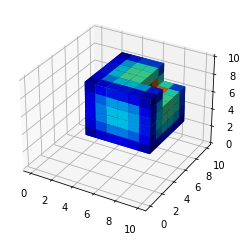

In [162]:
x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
z = np.linspace(0, 1, 10)
coo = np.stack([m.ravel() for m in np.meshgrid(x, y, z)], axis=1)
C = tree.query(torch.from_numpy(coo).float().cuda(), normalize=False)[0][:, -1]
C = C.cpu().detach().numpy()
C = C.reshape(len(x), len(y), len(z))
coo = coo.reshape(len(x), len(y), len(z), -1).transpose(3, 0, 1, 2)
minn, maxx = C.min(), C.max()
norm = matplotlib.colors.Normalize(minn, maxx)
m = plt.cm.ScalarMappable(norm=norm, cmap='jet')
m.set_array([])
fcolors = m.to_rgba(C.ravel())


fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
ax.voxels(C > 0.3, 
          facecolors=fcolors.reshape(C.shape[0], C.shape[1], C.shape[2], -1));
# ax.plot_surface(X, Y, Z, facecolors=C, cmap='inferno')

In [161]:
C.shape

(10, 10, 10)

In [126]:
C.shape

(20, 20, 20)

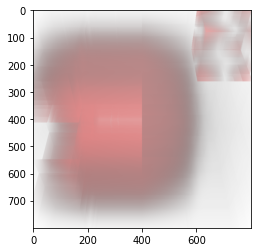

In [92]:
plot_ts(ts_dset, tree, use_ext=True, batch_size=10000)

### Test components

In [30]:
rays, imgs = next(data_iter)
imgs = imgs.to(device=dev)
rays_o = rays[:, 0].contiguous().to(device=dev)
rays_d = rays[:, 1].contiguous().to(device=dev)
rays_d /= torch.linalg.norm(rays_d, dim=1, keepdim=True)

# preds_p = tree(rays_o, rays_d, use_ext=False)
preds_c = tree(rays_o, rays_d, use_ext=True)

In [14]:
tree(rays_o[236:236+1], rays_d[236: 236+1], use_ext=True)

In [19]:
rays_o[236].cpu().numpy(), rays_d[236].cpu().numpy()

(array([ 2.232802 , -1.9462224,  2.7343762], dtype=float32),
 array([-0.5766932 ,  0.54368085, -0.6097837 ], dtype=float32))

In [33]:
rays_o_1 = torch.tensor([[2.232802 , -1.9462224,  2.7343762]]).cuda()
rays_d_1 = torch.tensor([[-0.5766932 ,  0.54368085, -0.6097837]]).cuda()
t_o_1 = tree.trasform_coords(rays_o_1)
preds_c = tree(rays_o_1, rays_d_1, use_ext=True)

tensor([[ 0.0159,  0.0356,  0.0393,  0.0310,  0.0234,  0.0240,  0.0296,  0.0351,
          0.0250,  0.0236,  0.0321,  0.0315,  0.0308,  0.0191,  0.0238,  0.0402,
          0.0333,  0.0264,  0.0133,  0.0162,  0.0321,  0.0321,  0.0343,  0.0222,
          0.0215,  0.0350,  0.0350,  0.0277,  0.0180,  0.0267,  0.0378,  0.0378,
          0.0210,  0.0137,  0.0299,  0.0367,  0.0367,  0.0244,  0.0154,  0.0265,
          0.0341,  0.0341,  0.0312,  0.0192,  0.0209,  0.0316,  0.0316,  0.0380,
          0.0231,  0.0226,  0.0436,  0.0352,  0.0269,  0.0169,  0.0216,  0.0363,
          0.0335,  0.0307,  0.0231,  0.0218,  0.0282,  0.0314,  0.0345,  0.0293,
          0.0321,  0.0393,  0.0384,  0.0354,  0.0283,  0.0331,  0.0422,  0.0416,
          0.0244,  0.0269,  0.0460,  0.0436,  0.0248,  0.0270,  0.0456,  0.0396,
          0.0291,  0.0330,  0.0413,  0.0336,  0.0334,  0.0389,  0.0371,  0.0277,
          0.0234,  0.0285,  0.0306,  0.0328,  0.0217,  0.0236,  0.0366,  0.0326,
          0.0285,  0.0158,  

In [18]:
# Sampling
t_o = tree.trasform_coords(rays_o[443:444])
pts_p = preds_p[1]
valid_p = preds_p[3]
pts_c = t_o.unsqueeze(1) + preds_c.ray_offsets.unsqueeze(-1) * rays_d.unsqueeze(1)
# print("ray_o", t_o)
# print("ray_d", rays_d, torch.linalg.norm(rays_d[0]))

In [19]:
# interpolation weights
w_p_ = preds_p[4]
w_c = preds_c.interpolation_weights
w_p = torch.zeros_like(w_c)
w_p.masked_scatter_(valid_p.unsqueeze(-1).repeat(1, 1, 8), w_p_);
((w_p[valid_p] - w_c[valid_p]).abs().sum(-1) > 1e-3).nonzero()

tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64)

In [14]:
# interpolation outputs
ival_c = preds_c.interpolated_vals
ival_p = preds_p[5]
((ival_p[0, 0] - ival_c[0, 0]).abs() > 1e-5).nonzero()

tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64)

In [15]:
# Outputs
out_c = preds_c.output_rgb
out_p = preds_p[0]
((out_c - out_p).abs() > 1e-5).nonzero()[:10]

tensor([], device='cuda:0', size=(0, 2), dtype=torch.int64)

#### Sampling tests

In [28]:
cube_sz = 32
def s_aabb(pos, invdir):
    pos = pos.clone()
    fs = []
    for i in range(5):
        pos *= 2
        f = torch.floor(pos)
        pos -= f
        fs.append(f)
    f = torch.cat(fs, 0).cpu()
    f = (f * (2 ** torch.arange(f.shape[0]))).sum()
    t1 = -pos * invdir
    t2 = t1 + invdir
    tmin = torch.max(torch.minimum(t1, t2))
    tmax = torch.min(torch.maximum(t1, t2))
#     print("Subcube tmin=%.3f - tmax=%.3f - f-pos %d" % (
#         tmin.item(), tmax.item(), int(f)))
    return tmin, tmax

def new_sample(ray_o, ray_d, invdir, n_samples_left, t, dt):
    if n_samples_left == 0:
        t += dt / 2  + 1e-4
        print("t prop: %f" % t.item())
        relpos = ray_o + t * ray_d
        print("relpos", relpos)
        s_tmin, s_tmax = s_aabb(relpos, invdir)
        print("s_tmin=%f s_tmax=%.10f" % (s_tmin, s_tmax))
        s_size = (s_tmax - s_tmin) / cube_sz
        n_samples_left = math.ceil(3 * s_size * cube_sz / 1.7321)
        dt = s_size / n_samples_left
        t += s_tmin / cube_sz + dt / 2
    else:
        t += dt
    n_samples_left -= 1
    
    return t, dt, n_samples_left
    
def sample_proposal(ray_o_norm, ray_d):
    invdir = 1 / (ray_d + 1e-8)
    
    t1 = -ray_o_norm * invdir
    t2 = t1 + invdir
    tmin = torch.max(torch.minimum(t1, t2))
    tmax = torch.min(torch.maximum(t1, t2))
    print("tmin", tmin, "tmax", tmax)
    
    
    t = t_new = tmin
    dt = 0
    n_samples_left = 0
    ts = []
    dts = []
    i = 0
    while True:
        print(f"Point at {ray_o_norm + t * ray_d}  t={t.item():.6e}  dt={dt:.4e}, i={i}")
        t_new, dt, n_samples_left = new_sample(ray_o_norm, ray_d, invdir, n_samples_left, t_new, dt)
        if t_new >= tmax: break
        ts.append(t.item())
        dts.append((t_new - t).item())
        t = t_new
        i += 1
    return torch.tensor(ts)

In [29]:
i = 0
ts = sample_proposal(t_o_1[i], rays_d_1[i])

tmin tensor(0.9047, device='cuda:0') tmax tensor(2.2965, device='cuda:0')
Point at tensor([0.8370, 0.2433, 1.0000], device='cuda:0')  t=9.047194e-01  dt=0.0000e+00, i=0
t prop: 0.904819
relpos tensor([0.8370, 0.2434, 0.9999], device='cuda:0')
s_tmin=-0.003197 s_tmax=0.3892941475
Point at tensor([0.8335, 0.2467, 0.9963], device='cuda:0')  t=9.108521e-01  dt=1.2265e-02, i=1
t prop: 0.917085
relpos tensor([0.8299, 0.2501, 0.9925], device='cuda:0')
s_tmin=-0.003199 s_tmax=0.9651357532
Point at tensor([0.8256, 0.2541, 0.9879], device='cuda:0')  t=9.245499e-01  dt=1.5130e-02, i=2
Point at tensor([0.8169, 0.2623, 0.9787], device='cuda:0')  t=9.396802e-01  dt=1.5130e-02, i=3
t prop: 0.947345
relpos tensor([0.8124, 0.2665, 0.9740], device='cuda:0')
s_tmin=-0.003198 s_tmax=0.2759004235
Point at tensor([0.8100, 0.2688, 0.9714], device='cuda:0')  t=9.516062e-01  dt=8.7218e-03, i=4
t prop: 0.956067
relpos tensor([0.8074, 0.2712, 0.9687], device='cuda:0')
s_tmin=-0.003200 s_tmax=0.5886782408
Point a

relpos tensor([0.3345, 0.7170, 0.4687], device='cuda:0')
s_tmin=-0.003203 s_tmax=0.1002647877
Point at tensor([0.3337, 0.7179, 0.4678], device='cuda:0')  t=1.777547e+00  dt=3.2334e-03, i=77
t prop: 1.779263
relpos tensor([0.3327, 0.7188, 0.4667], device='cuda:0')
s_tmin=-0.003203 s_tmax=1.1198091507
Point at tensor([0.3277, 0.7235, 0.4614], device='cuda:0')  t=1.787937e+00  dt=1.7547e-02, i=78
Point at tensor([0.3176, 0.7331, 0.4507], device='cuda:0')  t=1.805484e+00  dt=1.7547e-02, i=79
t prop: 1.814358
relpos tensor([0.3124, 0.7379, 0.4453], device='cuda:0')
s_tmin=-0.003202 s_tmax=0.4102441669
Point at tensor([0.3088, 0.7413, 0.4414], device='cuda:0')  t=1.820718e+00  dt=1.2920e-02, i=80
t prop: 1.827278
relpos tensor([0.3050, 0.7449, 0.4374], device='cuda:0')
s_tmin=-0.003197 s_tmax=0.2996575832
Point at tensor([0.3023, 0.7474, 0.4346], device='cuda:0')  t=1.831910e+00  dt=9.4642e-03, i=81
t prop: 1.836742
relpos tensor([0.2995, 0.7501, 0.4317], device='cuda:0')
s_tmin=-0.003203 s_

dt=0.008042 - t=1.940708 - relpos=0.748992 0.157146 0.000000 - s_tmin=-1.029374 - s_tmax=0.000000 - cube_sz=64.000000   --  new dt=0.008042  new t=-0.012063
dt=0.008042 - t=1.940808 - relpos=0.747622 0.156498 0.000000 - s_tmin=-1.029374 - s_tmax=0.000000 - cube_sz=64.000000   --  new dt=0.008042  new t=-0.012063


In [37]:
preds_c.intersection_pos[0, 10:20]

tensor([[0.7744, 0.3024, 0.9337],
        [0.7672, 0.3091, 0.9262],
        [0.7602, 0.3157, 0.9188],
        [0.7534, 0.3222, 0.9116],
        [0.7492, 0.3261, 0.9071],
        [0.7439, 0.3311, 0.9015],
        [0.7350, 0.3395, 0.8921],
        [0.7276, 0.3465, 0.8843],
        [0.7217, 0.3520, 0.8781],
        [0.7188, 0.3548, 0.8750]], device='cuda:0')

In [38]:
preds_c.ray_steps[0, 10:20]

tensor([0.0321, 0.0315, 0.0308, 0.0191, 0.0238, 0.0402, 0.0333, 0.0264, 0.0133,
        0.0162], device='cuda:0')

In [33]:
preds_c.ray_offsets[0, :25]

tensor([1.8111, 1.8115, 1.8160, 1.8240, 1.8320, 1.8401, 1.8468, 1.8522, 1.8575,
        1.8642, 1.8723, 1.8803, 1.8883, 1.8964, 1.9044, 1.9119, 1.9189, 1.9235,
        1.9285, 1.9366, 1.9286, 1.9367, 1.9287, 1.9368, 1.9288],
       device='cuda:0')

### 'Fast' training

In [53]:
optim = torch.optim.SGD(params=tree.parameters(), lr=1e6)
dev = 'cuda'

In [57]:
t_a = []
for i in range(100):
    rays, imgs = next(data_iter)
    imgs = imgs.to(device=dev)
    rays_o = rays[:, 0].contiguous().to(device=dev)
    rays_d = rays[:, 1].contiguous().to(device=dev)
    rays_d /= torch.linalg.norm(rays_d, dim=1, keepdim=True)
    
    t_a.append(time.time())
    preds = tree.forward_fast(rays_o, rays_d, imgs)
    optim.step()
    t_a[-1] = time.time() - t_a[-1]

In [58]:
plot_ts(ts_dset, tree, use_ext=True, batch_size=10000)

<IPython.core.display.Javascript object>

### Test the training process

tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0071, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0071, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0063, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0065, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0065, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0065, device='cuda:0', grad_fn=<MseLossBackward0>)


<IPython.core.display.Javascript object>


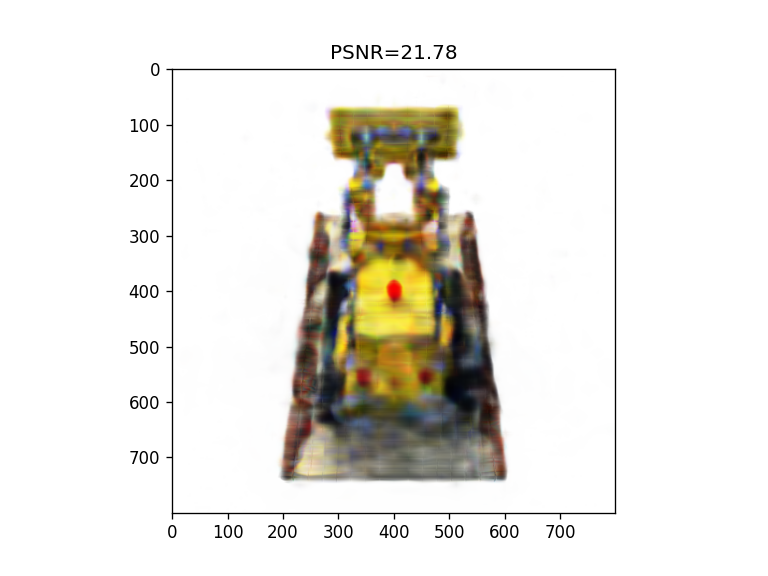

Density 10%=7.89 30%=14.12 50%=22.18 70%=38.34 90%=75.34
n_int=4681, n_nodes=37449, n_int_new=16384, n_nodes_fin=168521
Deduped corner coordinates from 1348160 to 181681
Copying 145744 interp points
tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0038, device

<IPython.core.display.Javascript object>


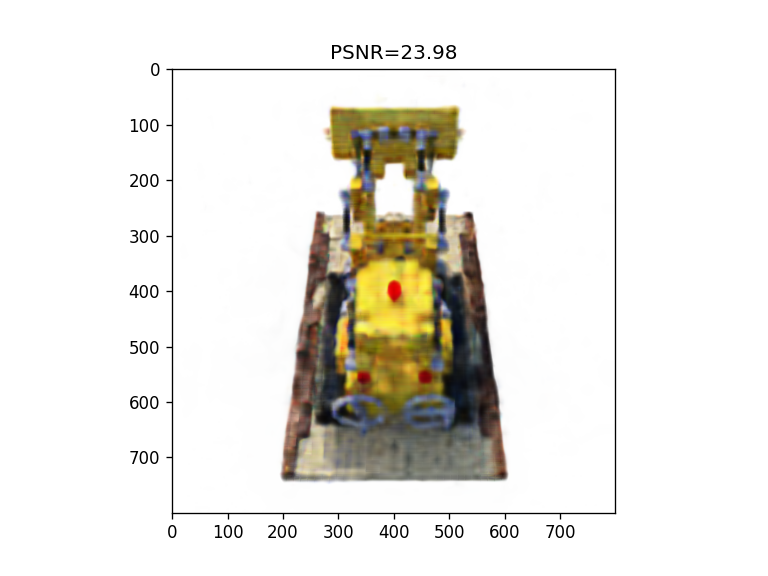

Density 10%=10.42 30%=16.10 50%=22.19 70%=32.21 90%=53.84
n_int=21065, n_nodes=168521, n_int_new=29491, n_nodes_fin=404449
Deduped corner coordinates from 3235584 to 475700
Copying 294030 interp points
tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0031, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0028, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0028, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0029, dev

<IPython.core.display.Javascript object>


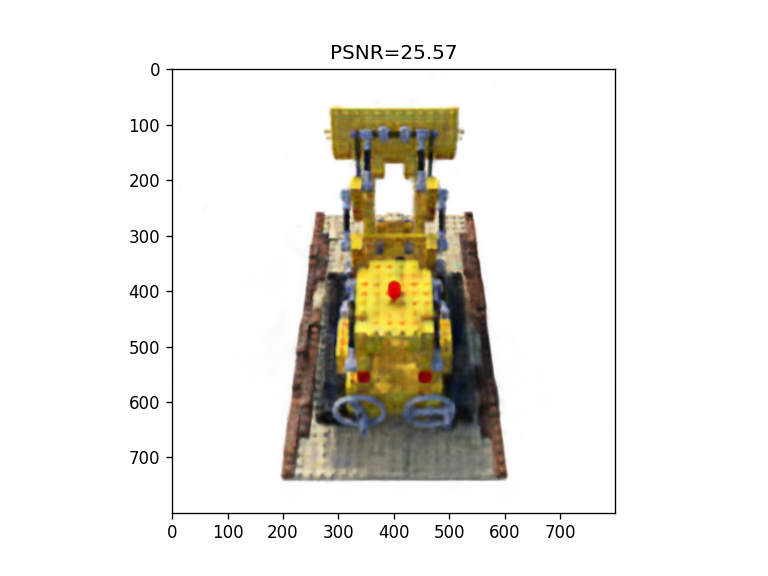

Density 10%=13.79 30%=20.81 50%=25.16 70%=31.13 90%=45.97
n_int=50556, n_nodes=404449, n_int_new=70779, n_nodes_fin=970681
Deduped corner coordinates from 7765440 to 1145634
Copying 669934 interp points


In [140]:
thresholds = [0.5, 0.8, 0.8]#, 110]#, 60, 50, 40]
t_f, t_b = [], []
for t in thresholds:
    optim = torch.optim.SGD(params=tree.parameters(), lr=1e6)
    dev = "cuda"
    for i in range(1500):
        rays, imgs = next(data_iter)
        imgs = imgs.to(device=dev)
        rays_o = rays[:, 0].contiguous().to(device=dev)
        rays_d = rays[:, 1].contiguous().to(device=dev)
        rays_d /= torch.linalg.norm(rays_d, dim=1, keepdim=True)

        t_f.append(time.time())
        preds = tree(rays_o, rays_d, use_ext=True)
        loss = F.mse_loss(preds, imgs)
        if (i + 1) % 100 == 0:
            print(loss)
        t_f[-1] = time.time() - t_f[-1]
        t_b.append(time.time())
        optim.zero_grad()
        loss.backward()
        optim.step()
        t_b[-1] = time.time() - t_b[-1]
    plot_ts(ts_dset, tree, use_ext=True, batch_size=10000)
    tree.refine_density(quantile=t, verbose=True)
#     tree.refine(copy_interp_data=True)

In [137]:
data_iter = iter(tr_loader)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5915e1b80>
Traceback (most recent call last):
  File "/home/giacomo/anaconda3/envs/torch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/giacomo/anaconda3/envs/torch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5915e1b80>

  File "/home/giacomo/anaconda3/envs/torch/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
      File "/home/giacomo/anaconda3/envs/torch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'
    AssertionErrorself._shutdown_workers(): 
can only test a child process  File "/home/giacomo/anaconda3/envs/torch/lib/python3

In [138]:
optim = torch.optim.SGD(params=tree.parameters(), lr=1e6)
dev = "cuda"
t_f, t_b = [], []
for i in range(1000):
    rays, imgs = next(data_iter)
    imgs = imgs.to(device=dev)
    rays_o = rays[:, 0].contiguous().to(device=dev)
    rays_d = rays[:, 1].contiguous().to(device=dev)
    
    t_f.append(time.time())
    preds = tree(rays_o, rays_d, use_ext=True)
    loss = F.mse_loss(preds, imgs)
    print(loss)
    t_f[-1] = time.time() - t_f[-1]
    t_b.append(time.time())
    optim.zero_grad()
    loss.backward()
    optim.step()
    t_b[-1] = time.time() - t_b[-1]

tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=

tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=

tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=

<IPython.core.display.Javascript object>


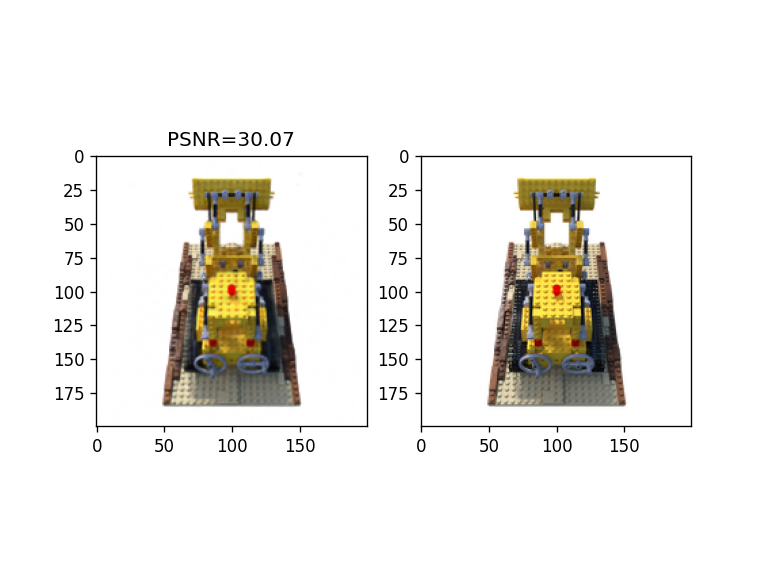

In [139]:
plot_ts(ts_dset, tree, use_ext=True, batch_size=10000)

In [124]:
g = tree.density_frequency()
g.max(), g.min(), g.mean()

(tensor(450.6892, device='cuda:0'),
 tensor(0.0083, device='cuda:0'),
 tensor(37.7241, device='cuda:0'))

In [127]:
(g > 70).nonzero().shape

torch.Size([169945, 1])

In [114]:
all_leaves = (tree.child[:tree.n_internal] < 0).nonzero(as_tuple=False)  # n_leaves, 4
high_complexity_leaves = all_leaves[g > 60]
print(high_complexity_leaves.shape[0])

83282


In [115]:
tree.refine(high_complexity_leaves, copy_interp_data=True)

n_int=136216, n_nodes=1089729, n_int_new=83282, n_nodes_fin=1755985
Deduped corner coordinates from 14047872 to 1126146
Copying 236934 interp points


In [121]:
optim = torch.optim.SGD(params=tree.parameters(), lr=1e6)

In [122]:
t_f, t_b = [], []
for i in range(1000):
    rays, imgs = next(data_iter)
    imgs = imgs.to(device=dev)
    rays_o = rays[:, 0].contiguous().to(device=dev)
    rays_d = rays[:, 1].contiguous().to(device=dev)
    rays_d /= torch.linalg.norm(rays_d, dim=1, keepdim=True)
    
    t_f.append(time.time())
    preds = tree(rays_o, rays_d, use_ext=True)
    loss = F.mse_loss(preds, imgs)
    print(loss)
    t_f[-1] = time.time() - t_f[-1]
    t_b.append(time.time())
    optim.zero_grad()
    loss.backward()
    optim.step()
    t_b[-1] = time.time() - t_b[-1]

tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=

tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=

tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=

tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=

tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=

tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=

tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=

tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=

<IPython.core.display.Javascript object>


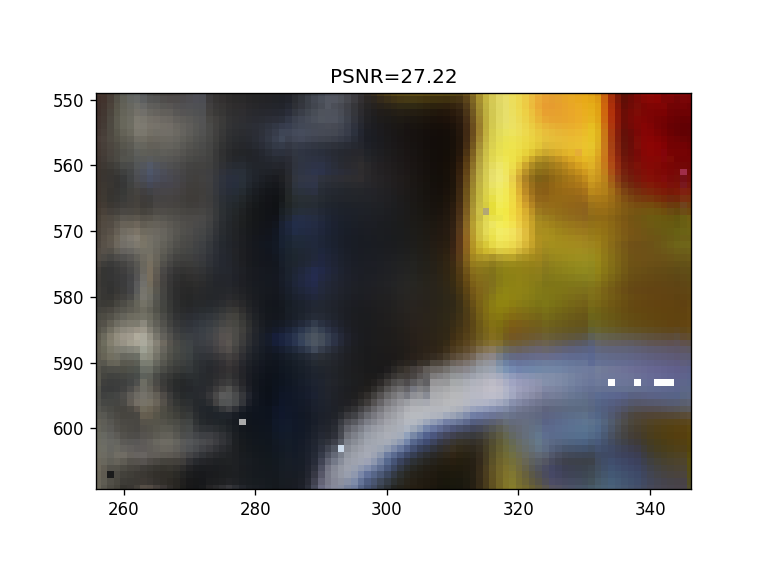

In [123]:
plot_ts(ts_dset, tree, use_ext=True, batch_size=10000)

In [38]:
64**3

262144

## Full CornerTree Experiments

In [6]:
cfg = config.get_cfg_defaults()
cfg.optim.batch_size = 8000
cfg.data.max_tr_frames = None
cfg.data.max_ts_frames = None
cfg.data.datadir = "/data/DATASETS/SyntheticNerf/lego"
cfg.data.downsample = 1
dev = "cuda"

In [7]:
tr_dset, tr_loader, ts_dset = init_datasets(cfg, dev)

Loading test data: 100%|██████████| 200/200 [00:11<00:00, 17.76it/s]


In [20]:
tree = CornerTree(sh_degree=2, init_internal=3_000_000, 
                  aabb=tr_dset.scene_bbox, near=2., far=6.,
                  init_rgb=0.01, init_sigma=0.1, sigma_thresh=1e-3, stop_thresh=1e-4,
                  max_intersections=512)
tree.refine()  # 2
tree.refine()  # 4
tree.refine()  # 8
tree.refine()  # 16
tree.refine()  # 32
tree.refine()  # 64
# tree.refine()  # 128
tree.cuda()

n_int=0, n_nodes=1, n_int_new=1, n_nodes_fin=9
Deduped corner coordinates from 64 to 27


IndexError: tensors used as indices must be long, byte or bool tensors

In [9]:
def run_test_epoch(test_dataset, batch_size, use_ext=True):
    psnr, mse = [], []
    e_start = time.time()

    for i, data in enumerate(test_dataset):
        rays_o, rays_d, imgs = data
        img_h, img_w = test_dataset.img_h, test_dataset.img_w
        preds = []
        for b in range(math.ceil(rays_o.shape[0] / batch_size)):
            brays_o = rays_o[b * batch_size: (b + 1) * batch_size].to("cuda")
            brays_d = rays_d[b * batch_size: (b + 1) * batch_size].to("cuda")
            preds.append(tree(brays_o, brays_d, use_ext).cpu())
        pred = torch.cat(preds, 0).view(img_h, img_w, 3)
        rgb = imgs.view(img_h, img_w, 3)
        mse.append(torch.mean((pred - rgb) ** 2).item())
        psnr.append(-10.0 * math.log(mse[-1]) / math.log(10))

    return {
        "mse": np.mean(mse),
        "psnr": np.mean(psnr),
        "time": time.time() - e_start,
    }

In [10]:
losses = []
thresholds = [0.8, 0.8]
test_log = []
optim = torch.optim.SGD(params=tree.parameters(), lr=1e6)
print_every = 1000

for e in range(1):
    if e == 1:
        tree.refine_density(quantile=thresholds[0], verbose=True)
        optim = torch.optim.SGD(params=tree.parameters(), lr=1e6)
    if e == 2:
        tree.refine_density(quantile=thresholds[1], verbose=True)
        optim = torch.optim.SGD(params=tree.parameters(), lr=1e6)
    e_start = time.time()
    t_fwd, t_bwd = [], []
    for i, data in enumerate(tr_loader):
        rays_o, rays_d, imgs = data
        imgs = imgs.to(device=dev)
        rays_o = rays_o.to(device=dev)
        rays_d = rays_d.to(device=dev)
        
        t_fwd.append(time.time())
        preds = tree(rays_o, rays_d, use_ext=True)
        loss = F.mse_loss(preds, imgs)
        t_fwd[-1] = time.time() - t_fwd[-1]
        
        t_bwd.append(time.time())
        optim.zero_grad()
        loss.backward()
        optim.step()
        t_bwd[-1] = time.time() - t_bwd[-1]

        losses.append(loss.item())
        if (i + 1) % print_every == 0:
            print(f"epoch {e} step {i + 1}. Loss={np.mean(losses[-print_every:]):.2e}")
    e_end = time.time()
    with torch.autograd.no_grad():
        test_log.append(run_test_epoch(ts_dset, batch_size=8000))
    print(f"Epoch {e} (training in {e_end - e_start:.2f}s, "
          f"fwd={np.sum(t_fwd):.2f}s, bwd={np.sum(t_bwd):.2f}s) "
          f"TEST MSE={test_log[-1]['mse']:.2e}  PSNR={test_log[-1]['psnr']:.2f}")
    print()

epoch 0 step 1000. Loss=7.49e-03
epoch 0 step 2000. Loss=2.82e-03
epoch 0 step 3000. Loss=2.26e-03
epoch 0 step 4000. Loss=1.99e-03
epoch 0 step 5000. Loss=1.81e-03
epoch 0 step 6000. Loss=1.67e-03
epoch 0 step 7000. Loss=1.58e-03
epoch 0 step 8000. Loss=1.49e-03
Epoch 0 (training in 426.11s, fwd=216.27s, bwd=8.49s) TEST MSE=2.17e-03  PSNR=26.89



<IPython.core.display.Javascript object>


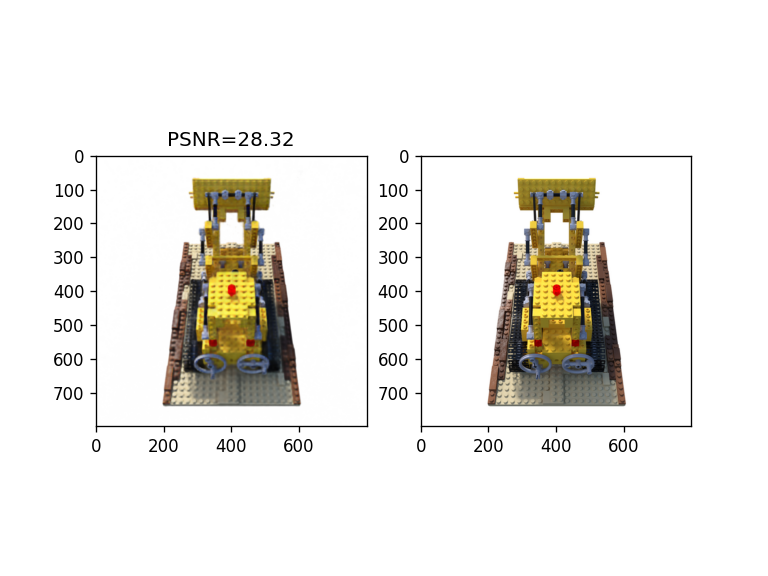

In [11]:
plot_ts(ts_dset, tree, use_ext=True, batch_size=10_000)

In [14]:
np.sum(t_fwd), np.sum(t_bwd), e_end - e_start

(215.2101833820343, 105.36838173866272, 409.12486577033997)

In [17]:
len(losses)

8000

## Test simple tree

In [4]:
tree = Octree(max_internal_nodes=1, initial_levels=1, 
              sh_degree=1, render_opt=init_render_opt(),
              branching=2, radius=None, center=None,
              parent_sum=True, dtype=torch.float32).cuda()

In [21]:
tree.data[:, :3]

tensor([[ 12.,  12.,  12.],
        [-11., -11., -11.],
        [-11., -11., -10.],
        [-11., -10., -11.],
        [-11., -10., -10.],
        [-10., -11., -11.],
        [-10., -11., -10.],
        [-10., -10., -11.],
        [-10., -10., -10.]], device='cuda:0', grad_fn=<SliceBackward0>)

In [19]:
 tree.query_interp(torch.tensor([[0.25, 0.75, 0.75]]).cuda())

(tensor([[10.8032, 10.8882, 10.8882,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0'),
 tensor([[0.0850, 0.1700, 0.1700, 0.3398, 0.0262, 0.0523, 0.0523, 0.1045]],
        device='cuda:0'),
 tensor([[ 4, -1, -1, -1,  8, -1, -1, -1]], device='cuda:0'))

In [10]:
with torch.autograd.no_grad():
    indices = torch.tensor([[0.25, 0.25, 0.25],
                            [0.25, 0.25, 0.75],
                            [0.25, 0.75, 0.25],
                            [0.25, 0.75, 0.75],
                            [0.75, 0.25, 0.25],
                            [0.75, 0.25, 0.75],
                            [0.75, 0.75, 0.25],
                            [0.75, 0.75, 0.75]]).cuda()
    values = torch.tensor([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                           [1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                           [1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                           [1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                           [2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                           [2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                           [2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                           [2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]).float().cuda()
    tree.set(indices, values, True)

In [7]:
tree[0], tree[1], tree[2], tree[3], tree[4], tree[5], tree[6], tree[7]

(N3TreeView(tensor([1., 1., 1.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([1., 1., 2.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([1., 2., 1.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([1., 2., 2.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([2., 1., 1.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([2., 1., 2.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([2., 2., 1.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([2., 2., 2.], device='cuda:0', grad_fn=<SelectBackward0>)))

In [8]:
tree._all_leaves()

tensor([[0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 1, 1],
        [0, 1, 0, 0],
        [0, 1, 0, 1],
        [0, 1, 1, 0],
        [0, 1, 1, 1]])

In [9]:
sel = (*tree._all_leaves()[:1].T,)
print(sel)
tree.refine(sel=sel)

(tensor([0]), tensor([0]), tensor([0]), tensor([0]))


True

In [10]:
tree.data

Parameter containing:
tensor([[[[[1., 1., 1.],
           [1., 1., 2.]],

          [[1., 2., 1.],
           [1., 2., 2.]]],


         [[[2., 1., 1.],
           [2., 1., 2.]],

          [[2., 2., 1.],
           [2., 2., 2.]]]],



        [[[[0., 0., 0.],
           [0., 0., 0.]],

          [[0., 0., 0.],
           [0., 0., 0.]]],


         [[[0., 0., 0.],
           [0., 0., 0.]],

          [[0., 0., 0.],
           [0., 0., 0.]]]]], device='cuda:0', requires_grad=True)

In [17]:
q_indices = torch.tensor([
    [0.125, 0.125, 0.125],
    [0.125, 0.125, 0.375],
    [0.125, 0.375, 0.125],
    [0.125, 0.375, 0.375],
    [0.375, 0.125, 0.125],
    [0.375, 0.125, 0.375],
    [0.375, 0.375, 0.125],
    [0.375, 0.375, 0.375],
    
    [0.125, 0.65, 0.125],
    [0.125, 0.55, 0.125],
    [0.125, 0.51, 0.125],
    [0.125, 0.50, 0.125],
    [0.125, 0.49, 0.125],
    [0.125, 0.45, 0.125],
    [0.125, 0.39, 0.125],
    
    [0.25, 0.25, 0.75],
    [0.25, 0.75, 0.25],
    [0.25, 0.75, 0.75],
    [0.75, 0.25, 0.25],
    [0.75, 0.25, 0.75],
    [0.75, 0.75, 0.25],
    [0.75, 0.75, 0.75]
]).cuda()
out = C_.query_interp(tree._spec(world=True), q_indices)
out

tensor([[1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [0.5625, 1.0125, 0.5625],
        [0.5625, 0.9000, 0.5625],
        [0.5625, 0.8550, 0.5625],
        [0.5625, 0.8438, 0.5625],
        [0.5400, 0.5400, 0.5400],
        [0.7000, 0.7000, 0.7000],
        [0.9400, 0.9400, 0.9400],
        [1.0000, 1.0000, 2.0000],
        [1.0000, 2.0000, 1.0000],
        [1.0000, 2.0000, 2.0000],
        [2.0000, 1.0000, 1.0000],
        [2.0000, 1.0000, 2.0000],
        [2.0000, 2.0000, 1.0000],
        [2.0000, 2.0000, 2.0000]], device='cuda:0')

In [16]:
q_indices = torch.tensor([[0.26, 0.75, 0.26], [0.8, 0.8, 0.8]]).cuda()
C_.query_interp(tree._spec(world=True), q_indices[0:1])

tensor([[1.0200, 2.0000, 1.0200]], device='cuda:0')

In [27]:
tree[0], tree[1], tree[2], tree[3], tree[4], tree[5], tree[6], tree[7], tree[8]

(N3TreeView(tensor([1., 1., 2.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([1., 2., 1.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([1., 2., 2.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([2., 1., 1.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([2., 1., 2.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([2., 2., 1.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([2., 2., 2.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([1., 1., 1.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([1., 1., 1.], device='cuda:0', grad_fn=<SelectBackward0>)))

In [28]:
tree._all_leaves().shape

torch.Size([15, 4])

In [27]:
indices = torch.tensor([[0.0, 0.0, 0.0], [1., 1., 1.]]).cuda()
values = torch.tensor([[3, 3, 3], [6, 6, 100000]]).float()
tree.set(indices, values)

In [25]:
tree[0], tree[1], tree[2], tree[3], tree[4], tree[5], tree[6], tree[7]

(N3TreeView(tensor([3., 3., 3.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([6.0000e+00, 6.0000e+00, 1.0000e+05], device='cuda:0',
        grad_fn=<SelectBackward0>)))

(N3TreeView(tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([6.0000e+00, 6.0000e+00, 1.0000e+05], device='cuda:0',
        grad_fn=<SelectBackward0>)))

In [13]:
q_indices = torch.tensor([[0.26, 0.75, 0.26], [0.8, 0.8, 0.8]]).cuda()
C_.query_interp(tree._spec(world=True), q_indices[0:1])

tensor([[2.4000e-03, 2.4000e-03, 4.0000e+01]], device='cuda:0')

In [19]:
C_.query_vertical(tree._spec(world=True), indices)

(tensor([[3.0000e+00, 3.0000e+00, 3.0000e+00],
         [6.0000e+00, 6.0000e+00, 1.0000e+05]], device='cuda:0'),
 tensor([0, 7], device='cuda:0'))

## Multiple Datasets + Super Resolution

### Joint training v2

In [122]:
cfg = config.get_cfg_defaults()
cfg.data.datadir = [
#     "/data/DATASETS/SyntheticNerf/lego",
#     "/data/DATASETS/SyntheticNerf/drums",
#     "/data/DATASETS/SyntheticNerf/ficus",
#     "/data/DATASETS/SyntheticNerf/mic",
#     "/data/DATASETS/SyntheticNerf/hotdog",
    "/data/DATASETS/SyntheticNerf/chair",
                   ]
cfg.data.max_tr_frames = None
cfg.data.max_ts_frames = 10
cfg.multi_sr.high_resolution = 256
cfg.multi_sr.low_resolution = 128
cfg.multi_sr.tree_height = 7
cfg.multi_sr.sr_model = "swin-ir"
cfg.multi_sr.patch_size = 96

cfg.corner_tree.max_intersections_per_node = 4

dev = "cuda"

In [123]:
tr_dset, ts_dset, tr_loader, ts_loader = init_multi_dset_v2(cfg)

Loading test data: 100%|██████████| 10/10 [00:00<00:00, 21.19it/s]


In [124]:
plenoxel_list = [init_plenoxels(cfg, tr_dset).cuda() for _ in range(len(cfg.data.datadir))]
# sr = init_sr(cfg).cuda()

n_int=0, n_nodes=1, n_int_new=1, n_nodes_fin=9
Deduped corner coordinates from 64 to 27
n_int=1, n_nodes=9, n_int_new=8, n_nodes_fin=73
Deduped corner coordinates from 576 to 125
n_int=9, n_nodes=73, n_int_new=64, n_nodes_fin=585
Deduped corner coordinates from 4672 to 729
n_int=73, n_nodes=585, n_int_new=512, n_nodes_fin=4681
Deduped corner coordinates from 37440 to 4913
n_int=585, n_nodes=4681, n_int_new=4096, n_nodes_fin=37449
Deduped corner coordinates from 299584 to 35937
n_int=4681, n_nodes=37449, n_int_new=32768, n_nodes_fin=299593
Deduped corner coordinates from 2396736 to 274625
n_int=37449, n_nodes=299593, n_int_new=262144, n_nodes_fin=2396745
Deduped corner coordinates from 19173952 to 2146689


In [125]:
plenoxel_lr = 0.1
swin_lr = 2e-4

params = []#{"params": sr.parameters(), "lr": swin_lr}]
for plenoxels in plenoxel_list:
    params.append({"params": plenoxels.parameters(), "lr": plenoxel_lr})
optim = torch.optim.Adam(params, lr=swin_lr)

In [116]:
mse_loss = torch.nn.MSELoss()
hr_loss_weight = 0.5
def joint_loss(pred_lr, lr, pred_hr, hr):
    return hr_loss_weight * mse_loss(pred_hr, hr) + (1 - hr_loss_weight) * mse_loss(pred_lr, lr)

for i in range(100):
    out = run_joint_epoch(plenoxel_list, sr, tr_loader, joint_loss, optim=optim, grad_scaler=None)
    print(f"{i:4d} ({out['time']:4.1f}s) MSE={out['mse']:.4f}   PSNR={out['psnr']:.2f}")

   0 (130.6s) MSE=0.0372   PSNR=15.96
   1 (129.7s) MSE=0.0096   PSNR=21.37
   2 (129.5s) MSE=0.0058   PSNR=23.77
   3 (128.5s) MSE=0.0047   PSNR=24.53
   4 (130.6s) MSE=0.0041   PSNR=25.27
   5 (131.4s) MSE=0.0038   PSNR=25.82
   6 (131.0s) MSE=0.0035   PSNR=25.93
   7 (128.7s) MSE=0.0031   PSNR=26.64
   8 (135.3s) MSE=0.0029   PSNR=26.96
   9 (133.6s) MSE=0.0027   PSNR=27.14
  10 (131.8s) MSE=0.0026   PSNR=27.66
  12 (136.5s) MSE=0.0022   PSNR=28.12
  13 (135.4s) MSE=0.0021   PSNR=28.18
  14 (136.4s) MSE=0.0020   PSNR=28.61
  15 (134.1s) MSE=0.0019   PSNR=28.84
  16 (133.8s) MSE=0.0019   PSNR=28.67
  17 (133.4s) MSE=0.0018   PSNR=29.04
  18 (134.7s) MSE=0.0017   PSNR=29.37
  19 (135.4s) MSE=0.0017   PSNR=29.40
  20 (135.0s) MSE=0.0017   PSNR=29.53
  21 (134.4s) MSE=0.0015   PSNR=30.00
  22 (135.2s) MSE=0.0015   PSNR=29.98
  23 (134.1s) MSE=0.0015   PSNR=29.93
  24 (134.5s) MSE=0.0015   PSNR=29.82
  25 (134.6s) MSE=0.0014   PSNR=30.29
  26 (136.3s) MSE=0.0014   PSNR=30.26
  27 (135.4s

In [126]:
for i in range(100):
    out = run_tree_epoch(plenoxel_list, tr_loader, loss_fn=torch.nn.MSELoss(), optim=optim)
    print(f"{i:4d} ({out['time']:4.1f}s) MSE={out['mse']:.4f}   PSNR={out['psnr']:.2f}")

   0 ( 2.9s) MSE=0.0224   PSNR=17.71
   1 ( 2.7s) MSE=0.0069   PSNR=22.75
   2 ( 2.7s) MSE=0.0035   PSNR=25.62
   3 ( 2.7s) MSE=0.0024   PSNR=27.28
   4 ( 2.6s) MSE=0.0019   PSNR=29.13
   5 ( 2.7s) MSE=0.0016   PSNR=29.16
   6 ( 2.6s) MSE=0.0012   PSNR=30.50
   7 ( 2.6s) MSE=0.0011   PSNR=31.51
   8 ( 2.6s) MSE=0.0010   PSNR=31.84
   9 ( 2.6s) MSE=0.0008   PSNR=32.14
  10 ( 2.6s) MSE=0.0009   PSNR=31.77
  11 ( 2.6s) MSE=0.0007   PSNR=33.11
  12 ( 2.6s) MSE=0.0008   PSNR=32.15
  13 ( 2.6s) MSE=0.0007   PSNR=33.07
  14 ( 2.6s) MSE=0.0007   PSNR=32.87
  15 ( 2.6s) MSE=0.0005   PSNR=33.65
  16 ( 2.6s) MSE=0.0005   PSNR=35.16
  17 ( 2.6s) MSE=0.0004   PSNR=34.77
  18 ( 2.6s) MSE=0.0005   PSNR=34.90
  19 ( 2.6s) MSE=0.0004   PSNR=35.38
  20 ( 2.6s) MSE=0.0004   PSNR=34.66
  21 ( 2.6s) MSE=0.0004   PSNR=34.98
  22 ( 2.6s) MSE=0.0004   PSNR=35.11
  23 ( 2.6s) MSE=0.0004   PSNR=35.46
  24 ( 2.6s) MSE=0.0004   PSNR=34.94
  25 ( 2.6s) MSE=0.0004   PSNR=35.48
  26 ( 2.6s) MSE=0.0003   PSNR=35.78
 

In [127]:
def test_loss(pred_lr, lr, pred_hr, hr):
    return F.mse_loss(pred_hr, hr)
with torch.no_grad():
    out = run_joint_epoch(plenoxel_list, sr, ts_loader, joint_loss_fn=test_loss,
                          optim=None, grad_scaler=None)
    print(f"Test-set MSE={out['mse']:.4f}   PSNR={out['psnr']:.2f}")

Test-set MSE=0.0005   PSNR=33.04


In [131]:
plot_ts_sr(ts_dset, plenoxel_list, sr, indep_sr_model_fw, plot_idx=9)

<IPython.core.display.Javascript object>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


### Joint training

In [9]:
def sr_model_fw(tree, sr, rays, dset):
    rays_o = rays[:, 0].contiguous().to(dev)
    rays_d = rays[:, 1].contiguous().to(dev)
    
    pred_lr = tree(rays_o, rays_d, use_ext=True)
    pred_lr_cnn = pred_lr.view(1, dset.low_resolution, dset.low_resolution, 3).permute(0, 3, 1, 2).contiguous()
    pred_hr = sr(pred_lr_cnn).view(3, -1).T
    
    return pred_lr, pred_hr

In [40]:
cfg = config.get_cfg_defaults()
cfg.data.datadir = ["/data/DATASETS/SyntheticNerf/lego",
                    "/data/DATASETS/SyntheticNerf/drums",
                    "/data/DATASETS/SyntheticNerf/ficus",
                    "/data/DATASETS/SyntheticNerf/mic",
                    "/data/DATASETS/SyntheticNerf/hotdog",
                   ]
cfg.data.max_tr_frames = None
cfg.data.max_ts_frames = 10
cfg.multi_sr.high_resolution = 512
cfg.multi_sr.low_resolution = 256
cfg.multi_sr.tree_height = 6
cfg.multi_sr.sr_model = "swin-ir"
dev = "cuda"

In [41]:
tr_dset, ts_dset = init_multi_dset(cfg)

Loading test data: 100%|██████████| 10/10 [00:00<00:00, 15.76it/s]


In [42]:
plenoxel_list = [init_plenoxels(cfg, tr_dset).cuda() for _ in range(len(cfg.data.datadir))]
sr = init_sr(cfg).cuda()

n_int=0, n_nodes=1, n_int_new=1, n_nodes_fin=9
Deduped corner coordinates from 64 to 27
n_int=1, n_nodes=9, n_int_new=8, n_nodes_fin=73
Deduped corner coordinates from 576 to 125
n_int=9, n_nodes=73, n_int_new=64, n_nodes_fin=585
Deduped corner coordinates from 4672 to 729
n_int=73, n_nodes=585, n_int_new=512, n_nodes_fin=4681
Deduped corner coordinates from 37440 to 4913
n_int=585, n_nodes=4681, n_int_new=4096, n_nodes_fin=37449
Deduped corner coordinates from 299584 to 35937
n_int=4681, n_nodes=37449, n_int_new=32768, n_nodes_fin=299593
Deduped corner coordinates from 2396736 to 274625
n_int=0, n_nodes=1, n_int_new=1, n_nodes_fin=9
Deduped corner coordinates from 64 to 27
n_int=1, n_nodes=9, n_int_new=8, n_nodes_fin=73
Deduped corner coordinates from 576 to 125
n_int=9, n_nodes=73, n_int_new=64, n_nodes_fin=585
Deduped corner coordinates from 4672 to 729
n_int=73, n_nodes=585, n_int_new=512, n_nodes_fin=4681
Deduped corner coordinates from 37440 to 4913
n_int=585, n_nodes=4681, n_int

In [43]:
plenoxel_lr = 0.1
swin_lr = 2e-4

params = [
    {"params": sr.parameters(), "lr": swin_lr},
]
for plenoxels in plenoxel_list:
    params.append({"params": plenoxels.parameters(), "lr": plenoxel_lr})
optim = torch.optim.Adam(params, lr=swin_lr)

In [44]:
# plenoxel_lr = 1e6
# cnn_lr = 1e-3
# cnn_momentum = 0.0
# params = [
#     {"params": sr.feature_extraction.parameters(), "momentum": cnn_momentum},
#     {"params": sr.shrink.parameters(), "momentum": cnn_momentum},
#     {"params": sr.map.parameters(), "momentum": cnn_momentum},
#     {"params": sr.expand.parameters(), "momentum": cnn_momentum},
#     {"params": sr.deconv.parameters(), "lr": cnn_lr * 0.1, "momentum": cnn_momentum},
# ]
# for plenoxels in plenoxel_list:
#     params.append({"params": plenoxels.parameters(), "lr": plenoxel_lr})
# optim = torch.optim.SGD(params, lr=cnn_lr)

In [45]:
hr_loss_weight = 0.5
lr_loss_weight = 1.0 - hr_loss_weight
for e in range(10):
    data_ids = np.random.permutation(len(tr_dset))
    hr_losses, lr_losses, losses = [], [], []
    for i, did in enumerate(data_ids):
        rays, pxls_lr, pxls_hr, scene_id = tr_dset[did]
        pxls_hr = pxls_hr.to(dev)
        pxls_lr = pxls_lr.to(dev)
        plenoxel = plenoxel_list[scene_id]

        optim.zero_grad()

        pred_pxls_lr, pred_pxls_hr = sr_model_fw(plenoxel, sr, rays, tr_dset)
        hr_loss = F.mse_loss(pred_pxls_hr, pxls_hr)
        lr_loss = F.mse_loss(pred_pxls_lr, pxls_lr)
        loss = hr_loss_weight * hr_loss + lr_loss_weight * lr_loss

        loss.backward()
        optim.step()

        hr_losses.append(hr_loss.item())
        lr_losses.append(lr_loss.item())
        losses.append(loss.item())
        if (i + 1) % 50 == 0:
            print("e=%3d.%4d  LR Loss=%.4f   HR Loss=%.4f  Loss=%.4f" % 
                  (e, i + 1, np.mean(lr_losses), np.mean(hr_losses), np.mean(losses)))

e=  0.  50  LR Loss=0.0402   HR Loss=0.0658  Loss=0.0530
e=  0. 100  LR Loss=0.0291   HR Loss=0.0433  Loss=0.0362
e=  0. 150  LR Loss=0.0237   HR Loss=0.0343  Loss=0.0290
e=  0. 200  LR Loss=0.0202   HR Loss=0.0288  Loss=0.0245
e=  0. 250  LR Loss=0.0176   HR Loss=0.0249  Loss=0.0212
e=  0. 300  LR Loss=0.0158   HR Loss=0.0222  Loss=0.0190
e=  0. 350  LR Loss=0.0145   HR Loss=0.0201  Loss=0.0173
e=  0. 400  LR Loss=0.0133   HR Loss=0.0184  Loss=0.0159
e=  0. 450  LR Loss=0.0124   HR Loss=0.0171  Loss=0.0148
e=  0. 500  LR Loss=0.0117   HR Loss=0.0160  Loss=0.0138
e=  1.  50  LR Loss=0.0042   HR Loss=0.0052  Loss=0.0047
e=  1. 100  LR Loss=0.0043   HR Loss=0.0053  Loss=0.0048
e=  1. 150  LR Loss=0.0041   HR Loss=0.0050  Loss=0.0046
e=  1. 200  LR Loss=0.0039   HR Loss=0.0048  Loss=0.0043
e=  1. 250  LR Loss=0.0038   HR Loss=0.0047  Loss=0.0043
e=  1. 300  LR Loss=0.0038   HR Loss=0.0046  Loss=0.0042
e=  1. 350  LR Loss=0.0037   HR Loss=0.0046  Loss=0.0042
e=  1. 400  LR Loss=0.0037   HR

<IPython.core.display.Javascript object>


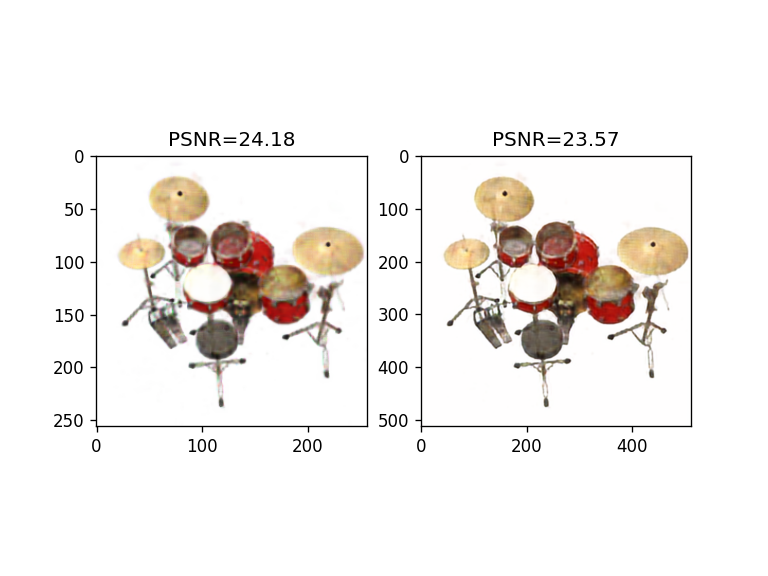

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [48]:
plot_ts_sr(ts_dset, plenoxel_list, sr, plot_idx=11)

### Independent Training

In [69]:
def indep_sr_model_fw(tree, sr, rays, dset):
    dev = "cuda"
    l_patch_size = rays.shape[0]
    rays_o = rays[:, :, 0, :].view(-1, 3).contiguous().to(dev)
    rays_d = rays[:, :, 1, :].view(-1, 3).contiguous().to(dev)
    pred_lr = tree(rays_o, rays_d, use_ext=True).reshape(l_patch_size, l_patch_size, 3)
    pred_hr = sr(pred_lr.permute(2, 0, 1).unsqueeze(0))  # 1, 3, nH, nW
    pred_hr = pred_hr.squeeze().permute(1, 2, 0)

    return pred_lr, pred_hr

In [84]:
cfg = config.get_cfg_defaults()
cfg.data.datadir = ["/data/DATASETS/SyntheticNerf/lego",
                    "/data/DATASETS/SyntheticNerf/drums",
                    "/data/DATASETS/SyntheticNerf/ficus",
                    "/data/DATASETS/SyntheticNerf/mic",
                    "/data/DATASETS/SyntheticNerf/hotdog",
                   ]
cfg.data.max_tr_frames = None
cfg.data.max_ts_frames = 10
cfg.multi_sr.high_resolution = 512
cfg.multi_sr.low_resolution = 128
cfg.multi_sr.tree_height = 7
cfg.multi_sr.sr_model = "swin-ir"
cfg.multi_sr.patch_size = 96

cfg.corner_tree.max_intersections_per_node = 4

dev = "cuda"

In [83]:
tr_dset, ts_dset, tr_loader, ts_loader = init_multi_dset_v2(cfg)

Loading test data: 100%|██████████| 10/10 [00:00<00:00, 16.51it/s]


In [85]:
plenoxel_list = [init_plenoxels(cfg, tr_dset).cuda() for _ in range(len(cfg.data.datadir))]
sr = init_sr(cfg).cuda()

n_int=0, n_nodes=1, n_int_new=1, n_nodes_fin=9
Deduped corner coordinates from 64 to 27
n_int=1, n_nodes=9, n_int_new=8, n_nodes_fin=73
Deduped corner coordinates from 576 to 125
n_int=9, n_nodes=73, n_int_new=64, n_nodes_fin=585
Deduped corner coordinates from 4672 to 729
n_int=73, n_nodes=585, n_int_new=512, n_nodes_fin=4681
Deduped corner coordinates from 37440 to 4913
n_int=585, n_nodes=4681, n_int_new=4096, n_nodes_fin=37449
Deduped corner coordinates from 299584 to 35937
n_int=4681, n_nodes=37449, n_int_new=32768, n_nodes_fin=299593
Deduped corner coordinates from 2396736 to 274625
n_int=37449, n_nodes=299593, n_int_new=262144, n_nodes_fin=2396745
Deduped corner coordinates from 19173952 to 2146689
n_int=0, n_nodes=1, n_int_new=1, n_nodes_fin=9
Deduped corner coordinates from 64 to 27
n_int=1, n_nodes=9, n_int_new=8, n_nodes_fin=73
Deduped corner coordinates from 576 to 125
n_int=9, n_nodes=73, n_int_new=64, n_nodes_fin=585
Deduped corner coordinates from 4672 to 729
n_int=73, n_

In [94]:
plenoxel_lr = 1e6
swin_lr = 2e-4 / 10

plenoxel_optims = [
    torch.optim.SGD(plenoxel.parameters(), lr=plenoxel_lr) for plenoxel in plenoxel_list
]
sr_optim = torch.optim.Adam(sr.parameters(), lr=swin_lr)

In [87]:
for i in range(100):
    out = run_tree_epoch(plenoxel_list, tr_loader, loss_fn=torch.nn.MSELoss(), optim=plenoxel_optims)
    print(f"{i:4d} ({out['time']:4.1f}s) MSE={out['mse']:.4f}   PSNR={out['psnr']:.2f}")

   0 ( 9.1s) MSE=0.0879  PSNR=11.94
   1 ( 8.1s) MSE=0.0587  PSNR=14.60
   2 ( 8.0s) MSE=0.0504  PSNR=16.05
   3 ( 7.8s) MSE=0.0389  PSNR=18.35
   4 ( 7.7s) MSE=0.0322  PSNR=19.63
   5 ( 7.8s) MSE=0.0235  PSNR=21.31
   6 ( 7.7s) MSE=0.0228  PSNR=21.59
   7 ( 7.6s) MSE=0.0213  PSNR=22.67
   8 ( 7.6s) MSE=0.0166  PSNR=23.78
   9 ( 7.6s) MSE=0.0148  PSNR=24.33
  10 ( 7.6s) MSE=0.0146  PSNR=24.97
  11 ( 7.6s) MSE=0.0131  PSNR=25.06
  12 ( 7.6s) MSE=0.0135  PSNR=25.25
  13 ( 7.5s) MSE=0.0132  PSNR=25.03
  14 ( 7.5s) MSE=0.0106  PSNR=26.02
  15 ( 7.5s) MSE=0.0113  PSNR=26.90
  16 ( 7.5s) MSE=0.0108  PSNR=27.01
  17 ( 7.5s) MSE=0.0095  PSNR=27.07
  18 ( 7.5s) MSE=0.0113  PSNR=27.28
  19 ( 7.5s) MSE=0.0086  PSNR=27.72
  20 ( 7.5s) MSE=0.0075  PSNR=28.82
  21 ( 7.4s) MSE=0.0087  PSNR=29.00
  22 ( 7.5s) MSE=0.0080  PSNR=28.72
  23 ( 7.4s) MSE=0.0063  PSNR=29.11
  24 ( 7.5s) MSE=0.0091  PSNR=28.45
  25 ( 7.5s) MSE=0.0073  PSNR=29.45
  26 ( 7.5s) MSE=0.0062  PSNR=29.37
  27 ( 7.3s) MSE=0.0062  PSN

In [88]:
plot_ts_sr(ts_dset, plenoxel_list, sr, indep_sr_model_fw, plot_idx=11)

<IPython.core.display.Javascript object>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [95]:
for i in range(20):
    out = run_sr_epoch(plenoxel_list, sr, tr_loader, loss_fn=torch.nn.MSELoss(), 
                       optim=sr_optim, grad_scaler=None)
    print(f"{i:4d} ({out['time']:4.1f}s) MSE={out['mse']:.4f}   PSNR={out['psnr']:.2f}")

   0 (27.6s) MSE=0.0040  PSNR=25.34
   1 (27.4s) MSE=0.0037  PSNR=25.60
   2 (27.1s) MSE=0.0035  PSNR=25.73
   3 (27.3s) MSE=0.0040  PSNR=25.55
   4 (27.1s) MSE=0.0039  PSNR=25.25
   5 (28.1s) MSE=0.0034  PSNR=26.11
   6 (27.5s) MSE=0.0037  PSNR=25.37
   7 (27.4s) MSE=0.0040  PSNR=25.63
   8 (27.5s) MSE=0.0037  PSNR=25.79
   9 (28.0s) MSE=0.0038  PSNR=25.69
  10 (28.1s) MSE=0.0035  PSNR=25.95
  11 (27.7s) MSE=0.0041  PSNR=25.11
  12 (27.3s) MSE=0.0036  PSNR=25.53
  13 (27.7s) MSE=0.0035  PSNR=25.86
  14 (27.9s) MSE=0.0036  PSNR=26.43
  15 (27.8s) MSE=0.0039  PSNR=25.38
  16 (27.4s) MSE=0.0041  PSNR=25.18
  17 (27.8s) MSE=0.0039  PSNR=25.64
  18 (27.6s) MSE=0.0034  PSNR=26.01
  19 (27.5s) MSE=0.0037  PSNR=25.71


In [96]:
with torch.no_grad():
    out = run_sr_epoch(plenoxel_list, sr, ts_loader, loss_fn=torch.nn.MSELoss(), 
                       optim=None, grad_scaler=None)
    print(f"Test-set MSE={out['mse']:.4f}   PSNR={out['psnr']:.2f}")

Test-set MSE=0.0055   PSNR=22.79


In [97]:
plot_ts_sr(ts_dset, plenoxel_list, sr, indep_sr_model_fw, plot_idx=21)

<IPython.core.display.Javascript object>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


## Quantization + Corner Tree

In [7]:
from sklearn.cluster import MiniBatchKMeans

In [8]:
cfg = config.get_cfg_defaults()
cfg.data.datadir = "/data/DATASETS/SyntheticNerf/lego"
cfg.optim.batch_size = 3000
cfg.data.max_tr_frames = None
cfg.data.max_ts_frames = 10
cfg.data.downsample = 1

cfg.corner_tree.max_intersections_per_node = 3
cfg.multi_sr.tree_height = 7
cfg.sh.degree = 2

dev = "cuda"

In [9]:
tr_dset, tr_loader, ts_dset = init_datasets(cfg, dev)

Loading test data: 100%|██████████| 10/10 [00:00<00:00, 22.16it/s]


In [16]:
tree = init_plenoxels(cfg, tr_dset)
torch.nn.init.uniform_(tree.data.weight, 0.01, 0.1);
tree.cuda();

n_int=0, n_nodes=1, n_int_new=1, n_nodes_fin=9
Deduped corner coordinates from 64 to 27
n_int=1, n_nodes=9, n_int_new=8, n_nodes_fin=73
Deduped corner coordinates from 576 to 125
n_int=9, n_nodes=73, n_int_new=64, n_nodes_fin=585
Deduped corner coordinates from 4672 to 729
n_int=73, n_nodes=585, n_int_new=512, n_nodes_fin=4681
Deduped corner coordinates from 37440 to 4913
n_int=585, n_nodes=4681, n_int_new=4096, n_nodes_fin=37449
Deduped corner coordinates from 299584 to 35937
n_int=4681, n_nodes=37449, n_int_new=32768, n_nodes_fin=299593
Deduped corner coordinates from 2396736 to 274625
n_int=37449, n_nodes=299593, n_int_new=262144, n_nodes_fin=2396745
Deduped corner coordinates from 19173952 to 2146689


In [17]:
optim = torch.optim.Adam(params=[
    {"params": tree.parameters(), "lr": 1e-1},
], lr=1e-1)
for i, (rays, imgs) in enumerate(tr_loader):
    imgs = imgs.to(device=dev)
    rays_o = rays[:, 0].contiguous().to(device=dev)
    rays_d = rays[:, 1].contiguous().to(device=dev)
    
    optim.zero_grad()
    rgb_preds = tree(rays_o, rays_d, use_ext=True)
    loss = F.mse_loss(rgb_preds, imgs)
    loss.backward()
    optim.step()
    if i > 200:
        break

KeyboardInterrupt: 

In [13]:
with torch.no_grad():
    all_weights = tree.data.weight[:tree.n_internal].detach().cpu()
    all_weights_np = all_weights.numpy()

In [14]:
kmeans = MiniBatchKMeans(n_clusters=128, init='random', max_iter=100, batch_size=3096, 
                         compute_labels=False)
kmeans.fit(all_weights_np)

MiniBatchKMeans(batch_size=3096, compute_labels=False, init='random',
                n_clusters=128)

In [15]:
centers_init = torch.from_numpy(kmeans.cluster_centers_).cuda()

In [17]:
quantizer = VectorQuantizerEMA(embedding_dim=tree.data_dim, num_embeddings=128, 
                               commitment_cost=0.01, decay=0.7)
with torch.no_grad():
#     quantizer.w.weight.copy_(centers_init)
#     quantizer.ema_w.copy_(centers_init)
    torch.nn.init.uniform_(quantizer.w.weight, 0.01, 0.1);
    quantizer.ema_w.copy_(quantizer.w.weight.detach());

In [18]:
qtree = QuantizedCornerTree(tree, quantizer).cuda()

In [19]:
optim = torch.optim.Adam(params=[
    {"params": tree.parameters(), "lr": 1e-1},
    {"params": quantizer.parameters(), "lr": 1e-1},
], lr=1e-1)

In [ ]:
qtree.train()
train_recon_error = []
train_perplexity = []
train_vq = []
print_every = 100
for i, (rays, imgs) in enumerate(tr_loader):
    imgs = imgs.to(device=dev)
    rays_o = rays[:, 0].contiguous().to(device=dev)
    rays_d = rays[:, 1].contiguous().to(device=dev)
    
    optim.zero_grad()

    vq_loss, perplexity, rgb_preds = qtree(rays_o, rays_d)
    recon_loss = F.mse_loss(rgb_preds, imgs)
    loss = vq_loss + recon_loss

    loss.backward()
    optim.step()

    train_recon_error.append(recon_loss.item())
    train_perplexity.append(perplexity.item())
    train_vq.append(vq_loss.item())
    
    if (i+1) % print_every == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_recon_error[-print_every:]))
        print('vq loss: %.3f' % np.mean(train_vq[-print_every:]))
        print('perplexity: %.3f' % np.mean(train_perplexity[-print_every:]))
        print()


100 iterations
recon_error: 0.046
vq loss: 0.001
perplexity: 5.964

200 iterations
recon_error: 0.029
vq loss: 0.003
perplexity: 8.875

300 iterations
recon_error: 0.023
vq loss: 0.006
perplexity: 8.311

400 iterations
recon_error: 0.020
vq loss: 0.008
perplexity: 8.005

500 iterations
recon_error: 0.020
vq loss: 0.010
perplexity: 9.106

600 iterations
recon_error: 0.018
vq loss: 0.011
perplexity: 10.812

700 iterations
recon_error: 0.018
vq loss: 0.013
perplexity: 11.712

800 iterations
recon_error: 0.016
vq loss: 0.013
perplexity: 13.675

900 iterations
recon_error: 0.017
vq loss: 0.014
perplexity: 14.072

1000 iterations
recon_error: 0.017
vq loss: 0.015
perplexity: 13.828

1100 iterations
recon_error: 0.016
vq loss: 0.016
perplexity: 12.924

1200 iterations
recon_error: 0.016
vq loss: 0.017
perplexity: 12.421

1300 iterations
recon_error: 0.015
vq loss: 0.017
perplexity: 12.045

1400 iterations
recon_error: 0.015
vq loss: 0.018
perplexity: 10.593

1500 iterations
recon_error: 0.014

<IPython.core.display.Javascript object>


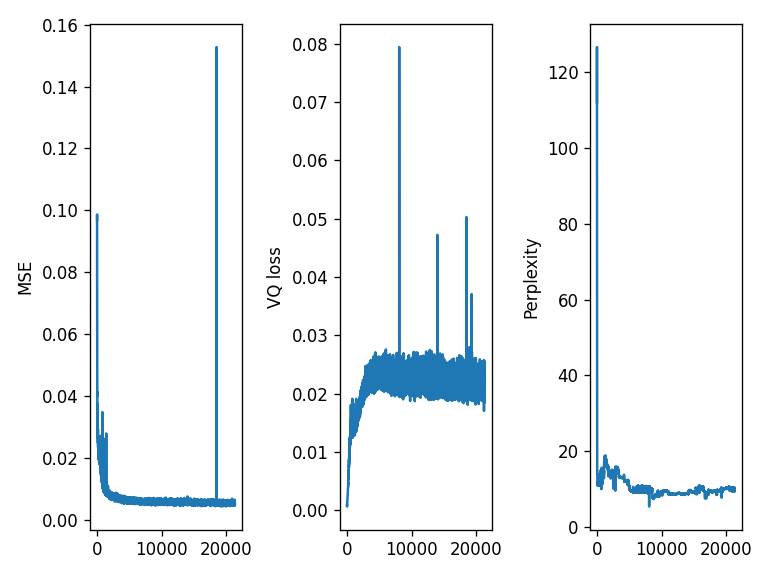

In [15]:
fig, ax = plt.subplots(ncols=3)
epochs = np.arange(len(train_recon_error))
ax[0].plot(epochs, train_recon_error)
ax[0].set_ylabel("MSE")
ax[1].plot(epochs, train_vq)
ax[1].set_ylabel("VQ loss")
ax[2].plot(epochs, train_perplexity)
ax[2].set_ylabel("Perplexity")
fig.tight_layout()

<IPython.core.display.Javascript object>


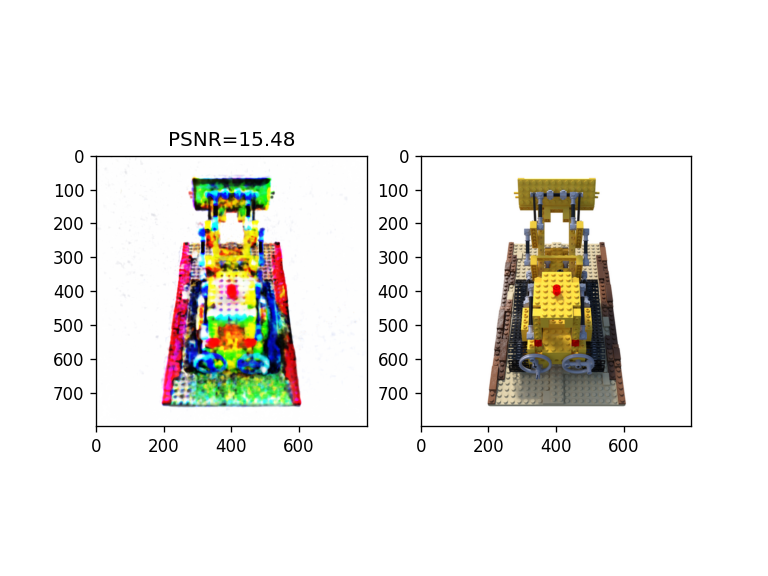

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [16]:
plot_ts(ts_dset, tree, use_ext=True, batch_size=10_000)

<IPython.core.display.Javascript object>


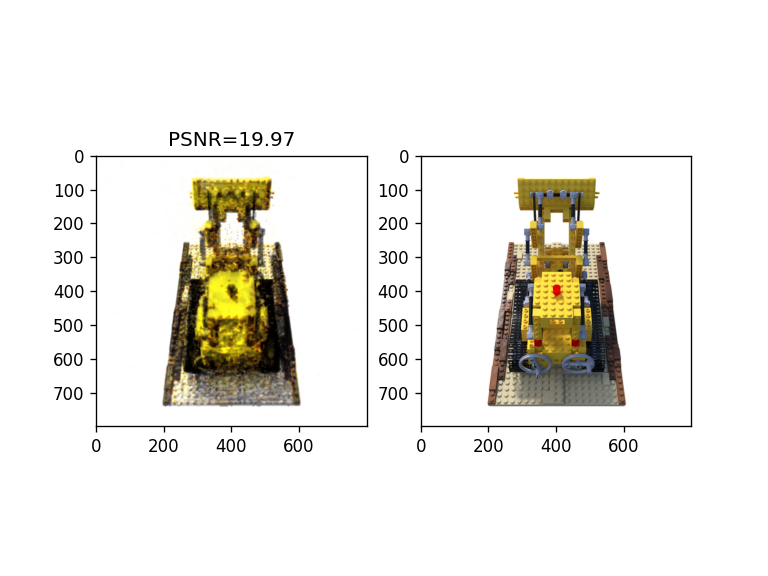

In [15]:
qtree.eval()
def qtree_call_wrap(rays_o, rays_d, use_ext):
    return qtree(rays_o, rays_d)[2]
plot_ts(ts_dset, qtree_call_wrap, use_ext=True, batch_size=1000)

## Regular Grid + Dictionary Learning

In [7]:
from plenoxels.regular_grid import RegularGrid, ShDictRender

In [8]:
def plot_wrap(model, grid_id=None):
    def wrapper(ro, rd, *args, **kwargs):
        if grid_id is not None:
            return model(ro, rd, grid_id)[0]
        return model(ro, rd)[0]
    return wrapper

In [9]:
class EMA():
    def __init__(self, weighting=0.9):
        self.weighting = weighting
        self.val = None
    def update(self, val):
        if self.val is None:
            self.val = val
        else:
            self.val = self.weighting * val + (1 - self.weighting) * self.val
    @property
    def value(self):
        return self.val

### Single dataset

In [10]:
cfg = config.get_cfg_defaults()
cfg.data.datadir = "/data/DATASETS/SyntheticNerf/lego"
cfg.data.resolution = 256
cfg.data.max_tr_frames = None
cfg.data.max_ts_frames = 10
cfg.data.downsample = 1

cfg.optim.batch_size = 4000

cfg.sh.degree = 0
cfg.sh.sh_encoder = "plenoxels"

dev = "cuda"

In [11]:
tr_dset, tr_loader, ts_dset = init_datasets(cfg, dev)

Loading test data: 100%|██████████| 10/10 [00:00<00:00, 20.41it/s]


In [12]:
num_atoms = 128
reso = torch.tensor([64] * 3, dtype=torch.int32)
grid = RegularGrid(
    resolution=reso, aabb=tr_dset.scene_bbox, data_dim=num_atoms,
    near_far=tr_dset.near_far, interpolate=False)
sh_encoder = init_sh_encoder(cfg, cfg.sh.degree)
render = ShDictRender(
    sh_deg=cfg.sh.degree, sh_encoder=sh_encoder, grid=grid,
    init_sigma=0.1, init_rgb=0.01, white_bkgd=True, 
    abs_light_thresh=1e-4, occupancy_thresh=1e-4)
render.cuda()

TypeError: __init__() got an unexpected keyword argument 'grid'

In [ ]:
grid_data = grid.data.cpu().detach().squeeze()

In [ ]:
grid_data.shape

In [ ]:
fig, ax = plt.subplots()
ax.boxplot([grid_data.view(64, -1)[i] for i in range(16)], whis=(1, 99));

In [210]:
(torch.abs(grid_data[:, :, :, :]) > 1e-0).nonzero()

tensor([[ 0,  0, 58, 53],
        [ 0,  1, 18, 58],
        [ 0, 16,  4, 25],
        ...,
        [63, 47, 46, 24],
        [63, 52, 44, 30],
        [63, 53, 43, 30]])

In [211]:
grid_data[:, 0, 58, 53]

tensor([-1.7042e+00,  7.5766e-05,  4.7181e-05,  3.2492e-05, -5.8547e-05,
         5.7615e-05, -5.7422e-07, -1.9562e-05,  6.5128e-05, -1.0750e+00,
         3.2810e-05, -1.0244e-05, -5.4895e-05,  9.8490e-06,  7.3875e-05,
        -1.9036e-05, -6.1584e-01,  4.3911e-05, -1.0464e-05,  1.6935e-05,
        -7.4825e-05, -1.1817e-04, -1.5766e-01,  4.6343e-05, -7.9829e-06,
         1.9035e-06,  2.7022e-05, -3.4449e-05,  5.2032e-05, -8.8170e-05,
         4.0012e-05, -2.6603e-06, -1.3820e-05,  4.9466e-05,  5.1792e-05,
        -5.8683e-05,  3.5129e-05,  2.3397e-05, -2.2271e-05,  5.6710e-05,
         2.4911e-05, -6.5559e-06, -4.3557e-05,  4.7164e-05,  2.2539e-05,
         5.1647e-05,  5.0471e-05,  2.3334e-05,  3.9597e-05, -8.2806e-05,
         3.8396e-05, -1.5706e-04,  3.4886e-01,  8.2408e-06,  7.8251e-06,
         1.3563e-05, -1.4787e-04, -1.2019e-04, -1.5495e-04,  9.3314e-06,
        -1.4151e-05, -4.1615e-05,  3.6877e-05, -9.0404e-06])

In [107]:
render.atoms[:, -1, ...].view(64, -1).sum(-1).argmax()

tensor(25, device='cuda:0')

In [89]:
render.atoms.shape

torch.Size([64, 4, 3, 3, 3])

In [108]:
render.atoms[25, -1]

tensor([[[6.3517, 9.4444, 7.0651],
         [5.7916, 8.0726, 6.5843],
         [5.8079, 7.8619, 7.1992]],

        [[4.7488, 9.0327, 6.6931],
         [5.4248, 9.9081, 7.1823],
         [4.4667, 8.9252, 6.7250]],

        [[4.9293, 8.1895, 5.6527],
         [4.9683, 8.2333, 5.1657],
         [4.3887, 8.3885, 6.2398]]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [224]:
optim = torch.optim.SGD(params=[
    {"params": grid.parameters(), "lr": 1e5},
    {"params": (render.atoms, ), "lr": 2e2}
])
optim = torch.optim.Adam(params=render.parameters(), lr=1e-3)
for i, (rays_o, rays_d, imgs) in enumerate(tr_loader):
    imgs = imgs.to(device=dev)
    rays_o = rays_o.to(device=dev)
    rays_d = rays_d.to(device=dev)
    
    optim.zero_grad()
    rgb_preds, alpha, depth = render(rays_o, rays_d)
    rec_loss = F.mse_loss(rgb_preds, imgs)
    l1_loss = 0.1 * torch.abs(grid.data).mean()
    loss = rec_loss + l1_loss
    loss.backward()
    optim.step()
    print(f"{i:5d} MSE: {rec_loss.item():.4f} L1: {l1_loss:.4f}")
    if i > 1500: break


    0 MSE: 0.0033 L1: 0.0030
    1 MSE: 0.0032 L1: 0.0030
    2 MSE: 0.0031 L1: 0.0030
    3 MSE: 0.0029 L1: 0.0030
    4 MSE: 0.0030 L1: 0.0030
    5 MSE: 0.0031 L1: 0.0030
    6 MSE: 0.0031 L1: 0.0030
    7 MSE: 0.0031 L1: 0.0030
    8 MSE: 0.0031 L1: 0.0030
    9 MSE: 0.0035 L1: 0.0030
   10 MSE: 0.0033 L1: 0.0030
   11 MSE: 0.0027 L1: 0.0029
   12 MSE: 0.0032 L1: 0.0029
   13 MSE: 0.0031 L1: 0.0029
   14 MSE: 0.0033 L1: 0.0029
   15 MSE: 0.0032 L1: 0.0029
   16 MSE: 0.0030 L1: 0.0029
   17 MSE: 0.0034 L1: 0.0029
   18 MSE: 0.0034 L1: 0.0029
   19 MSE: 0.0031 L1: 0.0029
   20 MSE: 0.0036 L1: 0.0029
   21 MSE: 0.0033 L1: 0.0029
   22 MSE: 0.0034 L1: 0.0029
   23 MSE: 0.0030 L1: 0.0029
   24 MSE: 0.0031 L1: 0.0029
   25 MSE: 0.0029 L1: 0.0029
   26 MSE: 0.0031 L1: 0.0029
   27 MSE: 0.0035 L1: 0.0029
   28 MSE: 0.0029 L1: 0.0029
   29 MSE: 0.0032 L1: 0.0029
   30 MSE: 0.0035 L1: 0.0029
   31 MSE: 0.0034 L1: 0.0029
   32 MSE: 0.0032 L1: 0.0029
   33 MSE: 0.0033 L1: 0.0029
   34 MSE: 0.0

  283 MSE: 0.0028 L1: 0.0026
  284 MSE: 0.0032 L1: 0.0026
  285 MSE: 0.0033 L1: 0.0026
  286 MSE: 0.0029 L1: 0.0026
  287 MSE: 0.0028 L1: 0.0026
  288 MSE: 0.0028 L1: 0.0026
  289 MSE: 0.0034 L1: 0.0026
  290 MSE: 0.0029 L1: 0.0026
  291 MSE: 0.0032 L1: 0.0026
  292 MSE: 0.0030 L1: 0.0026
  293 MSE: 0.0031 L1: 0.0026
  294 MSE: 0.0030 L1: 0.0026
  295 MSE: 0.0030 L1: 0.0026
  296 MSE: 0.0032 L1: 0.0026
  297 MSE: 0.0030 L1: 0.0026
  298 MSE: 0.0031 L1: 0.0026
  299 MSE: 0.0030 L1: 0.0026
  300 MSE: 0.0033 L1: 0.0026
  301 MSE: 0.0032 L1: 0.0026
  302 MSE: 0.0033 L1: 0.0026
  303 MSE: 0.0029 L1: 0.0026
  304 MSE: 0.0029 L1: 0.0026
  305 MSE: 0.0030 L1: 0.0026
  306 MSE: 0.0029 L1: 0.0026
  307 MSE: 0.0033 L1: 0.0026
  308 MSE: 0.0029 L1: 0.0026
  309 MSE: 0.0029 L1: 0.0026
  310 MSE: 0.0030 L1: 0.0026
  311 MSE: 0.0033 L1: 0.0026
  312 MSE: 0.0031 L1: 0.0026
  313 MSE: 0.0028 L1: 0.0026
  314 MSE: 0.0032 L1: 0.0026
  315 MSE: 0.0030 L1: 0.0026
  316 MSE: 0.0033 L1: 0.0026
  317 MSE: 0.0

  567 MSE: 0.0028 L1: 0.0024
  568 MSE: 0.0030 L1: 0.0024
  569 MSE: 0.0031 L1: 0.0024
  570 MSE: 0.0030 L1: 0.0024
  571 MSE: 0.0029 L1: 0.0024
  572 MSE: 0.0029 L1: 0.0024
  573 MSE: 0.0030 L1: 0.0024
  574 MSE: 0.0032 L1: 0.0024
  575 MSE: 0.0030 L1: 0.0024
  576 MSE: 0.0031 L1: 0.0024
  577 MSE: 0.0028 L1: 0.0024
  578 MSE: 0.0032 L1: 0.0024
  579 MSE: 0.0031 L1: 0.0024
  580 MSE: 0.0028 L1: 0.0024
  581 MSE: 0.0034 L1: 0.0024
  582 MSE: 0.0029 L1: 0.0024
  583 MSE: 0.0029 L1: 0.0024
  584 MSE: 0.0031 L1: 0.0024
  585 MSE: 0.0033 L1: 0.0024
  586 MSE: 0.0031 L1: 0.0024
  587 MSE: 0.0029 L1: 0.0024
  588 MSE: 0.0029 L1: 0.0024
  589 MSE: 0.0031 L1: 0.0024
  590 MSE: 0.0028 L1: 0.0024
  591 MSE: 0.0031 L1: 0.0024
  592 MSE: 0.0031 L1: 0.0024
  593 MSE: 0.0032 L1: 0.0024
  594 MSE: 0.0032 L1: 0.0024
  595 MSE: 0.0032 L1: 0.0024
  596 MSE: 0.0031 L1: 0.0024
  597 MSE: 0.0033 L1: 0.0024
  598 MSE: 0.0030 L1: 0.0024
  599 MSE: 0.0029 L1: 0.0024
  600 MSE: 0.0031 L1: 0.0024
  601 MSE: 0.0

  851 MSE: 0.0032 L1: 0.0023
  852 MSE: 0.0031 L1: 0.0023
  853 MSE: 0.0030 L1: 0.0023
  854 MSE: 0.0027 L1: 0.0023
  855 MSE: 0.0031 L1: 0.0023
  856 MSE: 0.0033 L1: 0.0023
  857 MSE: 0.0032 L1: 0.0023
  858 MSE: 0.0029 L1: 0.0023
  859 MSE: 0.0033 L1: 0.0023
  860 MSE: 0.0033 L1: 0.0023
  861 MSE: 0.0029 L1: 0.0023
  862 MSE: 0.0028 L1: 0.0023
  863 MSE: 0.0028 L1: 0.0023
  864 MSE: 0.0032 L1: 0.0023
  865 MSE: 0.0028 L1: 0.0023
  866 MSE: 0.0030 L1: 0.0023
  867 MSE: 0.0030 L1: 0.0023
  868 MSE: 0.0030 L1: 0.0023
  869 MSE: 0.0029 L1: 0.0023
  870 MSE: 0.0028 L1: 0.0023
  871 MSE: 0.0030 L1: 0.0023
  872 MSE: 0.0031 L1: 0.0023
  873 MSE: 0.0029 L1: 0.0023
  874 MSE: 0.0032 L1: 0.0023
  875 MSE: 0.0029 L1: 0.0023
  876 MSE: 0.0031 L1: 0.0023
  877 MSE: 0.0029 L1: 0.0023
  878 MSE: 0.0031 L1: 0.0023
  879 MSE: 0.0030 L1: 0.0023
  880 MSE: 0.0031 L1: 0.0023
  881 MSE: 0.0028 L1: 0.0023
  882 MSE: 0.0031 L1: 0.0023
  883 MSE: 0.0031 L1: 0.0023
  884 MSE: 0.0030 L1: 0.0023
  885 MSE: 0.0

 1135 MSE: 0.0026 L1: 0.0023
 1136 MSE: 0.0030 L1: 0.0023
 1137 MSE: 0.0027 L1: 0.0023
 1138 MSE: 0.0028 L1: 0.0023
 1139 MSE: 0.0031 L1: 0.0023
 1140 MSE: 0.0029 L1: 0.0023
 1141 MSE: 0.0032 L1: 0.0023
 1142 MSE: 0.0032 L1: 0.0023
 1143 MSE: 0.0030 L1: 0.0023
 1144 MSE: 0.0032 L1: 0.0023
 1145 MSE: 0.0030 L1: 0.0023
 1146 MSE: 0.0029 L1: 0.0023
 1147 MSE: 0.0028 L1: 0.0023
 1148 MSE: 0.0030 L1: 0.0023
 1149 MSE: 0.0030 L1: 0.0023
 1150 MSE: 0.0034 L1: 0.0023
 1151 MSE: 0.0031 L1: 0.0023
 1152 MSE: 0.0030 L1: 0.0023
 1153 MSE: 0.0028 L1: 0.0023
 1154 MSE: 0.0028 L1: 0.0023
 1155 MSE: 0.0033 L1: 0.0023
 1156 MSE: 0.0028 L1: 0.0023
 1157 MSE: 0.0029 L1: 0.0023
 1158 MSE: 0.0029 L1: 0.0023
 1159 MSE: 0.0029 L1: 0.0023
 1160 MSE: 0.0032 L1: 0.0023
 1161 MSE: 0.0032 L1: 0.0023
 1162 MSE: 0.0030 L1: 0.0023
 1163 MSE: 0.0033 L1: 0.0023
 1164 MSE: 0.0029 L1: 0.0023
 1165 MSE: 0.0029 L1: 0.0023
 1166 MSE: 0.0031 L1: 0.0023
 1167 MSE: 0.0030 L1: 0.0023
 1168 MSE: 0.0028 L1: 0.0023
 1169 MSE: 0.0

 1419 MSE: 0.0030 L1: 0.0022
 1420 MSE: 0.0030 L1: 0.0022
 1421 MSE: 0.0032 L1: 0.0022
 1422 MSE: 0.0031 L1: 0.0022
 1423 MSE: 0.0029 L1: 0.0022
 1424 MSE: 0.0031 L1: 0.0022
 1425 MSE: 0.0029 L1: 0.0022
 1426 MSE: 0.0028 L1: 0.0022
 1427 MSE: 0.0026 L1: 0.0022
 1428 MSE: 0.0029 L1: 0.0022
 1429 MSE: 0.0028 L1: 0.0022
 1430 MSE: 0.0028 L1: 0.0022
 1431 MSE: 0.0030 L1: 0.0022
 1432 MSE: 0.0028 L1: 0.0022
 1433 MSE: 0.0028 L1: 0.0022
 1434 MSE: 0.0027 L1: 0.0022
 1435 MSE: 0.0032 L1: 0.0022
 1436 MSE: 0.0029 L1: 0.0022
 1437 MSE: 0.0031 L1: 0.0022
 1438 MSE: 0.0029 L1: 0.0022
 1439 MSE: 0.0026 L1: 0.0022
 1440 MSE: 0.0028 L1: 0.0022
 1441 MSE: 0.0030 L1: 0.0022
 1442 MSE: 0.0029 L1: 0.0022
 1443 MSE: 0.0032 L1: 0.0022
 1444 MSE: 0.0027 L1: 0.0022
 1445 MSE: 0.0033 L1: 0.0022
 1446 MSE: 0.0032 L1: 0.0022
 1447 MSE: 0.0029 L1: 0.0022
 1448 MSE: 0.0030 L1: 0.0022
 1449 MSE: 0.0027 L1: 0.0022
 1450 MSE: 0.0030 L1: 0.0022
 1451 MSE: 0.0030 L1: 0.0022
 1452 MSE: 0.0032 L1: 0.0022
 1453 MSE: 0.0

In [ ]:
1e6, 1e3 = 1000 0.0033
1e5, 1e2 = 1000 0.0050
Adam 5e-2 = 1000 0.0032

<IPython.core.display.Javascript object>


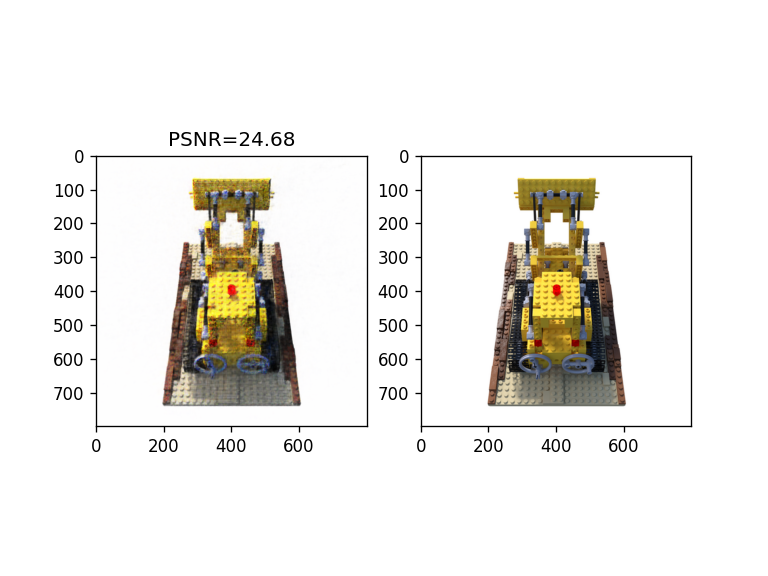

In [225]:
plot_ts(ts_dset, plot_wrap(render), use_ext=True, batch_size=8_000)

### Multiple Datasets

In [10]:
cfg = config.get_cfg_defaults()
cfg.data.resolution = 512
cfg.data.max_tr_frames = None
cfg.data.max_ts_frames = 10
cfg.data.downsample = 1

cfg.optim.batch_size = 2000

cfg.sh.degree = 2
cfg.sh.sh_encoder = "plenoxels"

dev = "cuda"

In [11]:
data_dirs = [
    "/data/DATASETS/SyntheticNerf/lego",
    "/data/DATASETS/SyntheticNerf/ship",
    "/data/DATASETS/SyntheticNerf/chair",
    "/data/DATASETS/SyntheticNerf/drums/",
    "/data/DATASETS/SyntheticNerf/ficus/",
]

In [12]:
tr_dsets, tr_loaders, ts_dsets = [], [], []
for dd in data_dirs:
    cfg.data.datadir = dd
    tr_dset, tr_loader, ts_dset = init_datasets(cfg, dev)
    tr_dsets.append(tr_dset)
    tr_loaders.append(tr_loader)
    ts_dsets.append(ts_dset)

Loading test data: 100%|██████████| 10/10 [00:00<00:00, 24.95it/s]


In [13]:
def init_renderers(cfg, dsets, num_atoms, resolution, fine_resolution, interpolate):
    reso = torch.tensor([resolution] * 3, dtype=torch.int32)
    grids = []
    for dset in dsets:
        grids.append(RegularGrid(
            resolution=reso, aabb=dset.scene_bbox, data_dim=num_atoms,
            near_far=dset.near_far, interpolate=interpolate))
    
    sh_encoder = init_sh_encoder(cfg, cfg.sh.degree)
    
    render = ShDictRender(
        sh_deg=cfg.sh.degree, sh_encoder=sh_encoder, grids=grids,
        fine_reso=fine_resolution,
        init_sigma=0.1, init_rgb=0.01, white_bkgd=True, 
        abs_light_thresh=1e-4, occupancy_thresh=1e-4)
    print(f"Initialized renderer {render}")
    return render

In [14]:
num_atoms = 128
resolution = 64
fine_reso = 7
interpolate = True
renderer = init_renderers(cfg, tr_dsets, num_atoms, resolution, fine_reso, interpolate)
renderer.cuda()

Initialized renderer ShDictRender(grids=ModuleList(
  (0): RegularGrid(data_dim=128, interpolate=True, aabb=tensor([[-1.3000, -1.3000, -1.3000],
          [ 1.3000,  1.3000,  1.3000]]), resolution=tensor([64., 64., 64.]))
  (1): RegularGrid(data_dim=128, interpolate=True, aabb=tensor([[-1.3000, -1.3000, -1.3000],
          [ 1.3000,  1.3000,  1.3000]]), resolution=tensor([64., 64., 64.]))
  (2): RegularGrid(data_dim=128, interpolate=True, aabb=tensor([[-1.3000, -1.3000, -1.3000],
          [ 1.3000,  1.3000,  1.3000]]), resolution=tensor([64., 64., 64.]))
  (3): RegularGrid(data_dim=128, interpolate=True, aabb=tensor([[-1.3000, -1.3000, -1.3000],
          [ 1.3000,  1.3000,  1.3000]]), resolution=tensor([64., 64., 64.]))
  (4): RegularGrid(data_dim=128, interpolate=True, aabb=tensor([[-1.3000, -1.3000, -1.3000],
          [ 1.3000,  1.3000,  1.3000]]), resolution=tensor([64., 64., 64.]))
), num_atoms=128, data_dim=28, fine_reso=7, white_bkgd=True)


ShDictRender(grids=ModuleList(
  (0): RegularGrid(data_dim=128, interpolate=True, aabb=tensor([[-1.3000, -1.3000, -1.3000],
          [ 1.3000,  1.3000,  1.3000]]), resolution=tensor([64., 64., 64.]))
  (1): RegularGrid(data_dim=128, interpolate=True, aabb=tensor([[-1.3000, -1.3000, -1.3000],
          [ 1.3000,  1.3000,  1.3000]]), resolution=tensor([64., 64., 64.]))
  (2): RegularGrid(data_dim=128, interpolate=True, aabb=tensor([[-1.3000, -1.3000, -1.3000],
          [ 1.3000,  1.3000,  1.3000]]), resolution=tensor([64., 64., 64.]))
  (3): RegularGrid(data_dim=128, interpolate=True, aabb=tensor([[-1.3000, -1.3000, -1.3000],
          [ 1.3000,  1.3000,  1.3000]]), resolution=tensor([64., 64., 64.]))
  (4): RegularGrid(data_dim=128, interpolate=True, aabb=tensor([[-1.3000, -1.3000, -1.3000],
          [ 1.3000,  1.3000,  1.3000]]), resolution=tensor([64., 64., 64.]))
), num_atoms=128, data_dim=28, fine_reso=7, white_bkgd=True)

In [15]:
optims = []
for i in range(len(renderer.grids)):
    optims.append(torch.optim.Adam(
        (renderer.atoms, renderer.grids[i].data), lr=1e-2
    ))

In [18]:
def train_epoch(renderer, data_loaders, optims):
    batches_per_dset = 10
    max_tot_steps = 20_000 * len(data_loaders)
    eta_min = 1e-5
    ema_weight = 0.5
    l1_loss_coef = 0.1
    lr_scheds = [
        torch.optim.lr_scheduler.CosineAnnealingLR(
            optim, T_max=max_tot_steps // len(optims), eta_min=eta_min)
        for optim in optims
    ]
    
    iters = [iter(dl) for dl in data_loaders]
    tot_steps = 0
    time_s = time.time()
    losses = [{"mse": EMA(ema_weight), "l1": EMA(ema_weight)} for _ in range(len(data_loaders))]
    while len([it for it in iters if it is not None]) > 0:
        try:
            for dset_id, dset in enumerate(iters):
                if dset is None:
                    continue
                optim = optims[dset_id]
                lr_sched = lr_scheds[dset_id]
                for i in range(batches_per_dset):
                    if tot_steps >= max_tot_steps:
                        raise StopIteration("Maximum steps reached")
                    rays_o, rays_d, imgs = next(dset)
                    imgs = imgs.to(device=dev)
                    rays_o = rays_o.to(device=dev)
                    rays_d = rays_d.to(device=dev)
    
                    optim.zero_grad()
                    rgb_preds, alpha, depth = renderer(rays_o, rays_d, grid_id=dset_id)
                    rec_loss = F.mse_loss(rgb_preds, imgs)
                    l1_loss = l1_loss_coef * torch.abs(renderer.grids[dset_id].data).mean()
                    loss = rec_loss + l1_loss
                    loss.backward()
                    optim.step()
                    lr_sched.step()
                    
                    losses[dset_id]["mse"].update(rec_loss.item())
                    losses[dset_id]["l1"].update(l1_loss.item())
                    tot_steps += 1
                    
                    if tot_steps % 100 == 0:
                        print(f"{tot_steps:6d}  ", end="")
                        for did, loss in enumerate(losses):
                            print(f"D{did}: ", end="")
                            for lname, lval in loss.items():
                                print(f"{lname}={lval.value:.4f} ", end="")
                            print("  ", end="")
                        print()
                    if tot_steps % 1000 == 0:
                        print("Time for 1000 steps: %.2fs" % (time.time() - time_s))
                        time_s = time.time()
        except StopIteration:
            print(f"Dataset {dset_id} finished")
            iters[dset_id] = None

In [ ]:
train_epoch(renderer, tr_loaders, optims)

In [17]:
batches_per_dset = 10
max_tot_steps = 20_000 * len(tr_loaders)
eta_min = 1e-5
ema_weight = 0.5
l1_loss_coef = 0.1
lr_scheds = [
    torch.optim.lr_scheduler.CosineAnnealingLR(
        optim, T_max=max_tot_steps // len(optims), eta_min=eta_min)
    for optim in optims
]

iters = [iter(dl) for dl in tr_loaders]
tot_steps = 0
time_s = time.time()
losses = [{"mse": EMA(ema_weight), "l1": EMA(ema_weight)} for _ in range(len(tr_loaders))]
while len([it for it in iters if it is not None]) > 0:
    try:
        for dset_id, dset in enumerate(iters):
            if dset is None:
                continue
            optim = optims[dset_id]
            lr_sched = lr_scheds[dset_id]
            print(f"dset {dset_id} - ", end="")
            for i in range(batches_per_dset):
                print(f"{i} ", end="", flush=True)
                if tot_steps >= max_tot_steps:
                    raise StopIteration("Maximum steps reached")
                if tot_steps == 744:
                    raise StopIteration()
                rays_o, rays_d, imgs = next(dset)
                imgs = imgs.to(device=dev)
                rays_o = rays_o.to(device=dev)
                rays_d = rays_d.to(device=dev)

                optim.zero_grad()
                rgb_preds, alpha, depth = renderer(rays_o, rays_d, grid_id=dset_id)
                rec_loss = F.mse_loss(rgb_preds, imgs)
                l1_loss = l1_loss_coef * torch.abs(renderer.grids[dset_id].data).mean()
                loss = rec_loss + l1_loss
                loss.backward()
                optim.step()
                lr_sched.step()

                losses[dset_id]["mse"].update(rec_loss.item())
                losses[dset_id]["l1"].update(l1_loss.item())
                tot_steps += 1

                if tot_steps % 100 == 0:
                    print(f"\n{tot_steps:6d}  ", end="")
                    for did, loss in enumerate(losses):
                        print(f"D{did}: ", end="")
                        for lname, lval in loss.items():
                            print(f"{lname}={lval.value:.4f} ", end="")
                        print("  ", end="")
                    print()
                if tot_steps % 1000 == 0:
                    print("\nTime for 1000 steps: %.2fs" % (time.time() - time_s))
                    time_s = time.time()
            print("")
    except StopIteration:
        print(f"Dataset {dset_id} finished")
        iters[dset_id] = None

dset 0 - 0 1 2 3 4 5 6 7 8 9 
dset 1 - 0 1 2 3 4 5 6 7 8 9 
dset 2 - 0 1 2 3 4 5 6 7 8 9 
dset 3 - 0 1 2 3 4 5 6 7 8 9 
dset 4 - 0 1 2 3 4 5 6 7 8 9 
dset 0 - 0 1 2 3 4 5 6 7 8 9 
dset 1 - 0 1 2 3 4 5 6 7 8 9 
dset 2 - 0 1 2 3 4 5 6 7 8 9 
dset 3 - 0 1 2 3 4 5 6 7 8 9 
dset 4 - 0 1 2 3 4 5 6 7 8 9 
   100  D0: mse=0.0000 l1=0.0001   D1: mse=0.0000 l1=0.0001   D2: mse=0.0000 l1=0.0001   D3: mse=0.0000 l1=0.0001   D4: mse=0.0000 l1=0.0001   

dset 0 - 0 1 2 3 4 5 6 7 8 9 
dset 1 - 0 1 2 3 4 5 6 7 8 9 
dset 2 - 0 1 2 3 4 5 6 7 8 9 
dset 3 - 0 1 2 3 4 5 6 7 8 9 
dset 4 - 0 1 2 3 4 5 6 7 8 9 
dset 0 - 0 1 2 3 4 5 6 7 8 9 
dset 1 - 0 1 2 3 4 5 6 7 8 9 
dset 2 - 0 1 2 3 4 5 6 7 8 9 
dset 3 - 0 1 2 3 4 5 6 7 8 9 
dset 4 - 0 1 2 3 4 5 6 7 8 9 
   200  D0: mse=0.0000 l1=0.0000   D1: mse=0.0000 l1=0.0000   D2: mse=0.0000 l1=0.0000   D3: mse=0.0000 l1=0.0000   D4: mse=0.0000 l1=0.0000   

dset 0 - 0 1 2 3 4 5 6 7 8 9 
dset 1 - 0 1 2 3 4 5 6 7 8 9 
dset 2 - 0 1 2 3 4 5 6 7 8 9 
dset 3 - 0 1 2 3 4 5

In [18]:
for i, b in enumerate(tr_loaders[4]):
    if i == 144:
        break

In [19]:
rays_o, rays_d, imgs = b

In [18]:
renderer.atoms.size(), renderer.atoms.stride()

(torch.Size([128, 343, 28]), (9604, 28, 1))

In [27]:
N, S, D, R = 1, 128, 28, 7

In [28]:
total_atoms_size = S * R**3 * D
print(f"{total_atoms_size=}")

total_atoms_size=1229312


In [29]:
offx = D
offy = D * R
offz = D * R * R
print(f"{offx=} {offy=} {offz=}")

offx=28 offy=196 offz=1372


In [30]:
A_offset = offx * (R - 2) + offy * (R - 2) + offz * (R - 2) + (D - 1)
for s in range(128):
    print(A_offset + offx + offy + offz)
    A_offset += 9604

9603
19207
28811
38415
48019
57623
67227
76831
86435
96039
105643
115247
124851
134455
144059
153663
163267
172871
182475
192079
201683
211287
220891
230495
240099
249703
259307
268911
278515
288119
297723
307327
316931
326535
336139
345743
355347
364951
374555
384159
393763
403367
412971
422575
432179
441783
451387
460991
470595
480199
489803
499407
509011
518615
528219
537823
547427
557031
566635
576239
585843
595447
605051
614655
624259
633863
643467
653071
662675
672279
681883
691487
701091
710695
720299
729903
739507
749111
758715
768319
777923
787527
797131
806735
816339
825943
835547
845151
854755
864359
873963
883567
893171
902775
912379
921983
931587
941191
950795
960399
970003
979607
989211
998815
1008419
1018023
1027627
1037231
1046835
1056439
1066043
1075647
1085251
1094855
1104459
1114063
1123667
1133271
1142875
1152479
1162083
1171687
1181291
1190895
1200499
1210103
1219707
1229311


9603
11199
20803
30407
40011
49615
59219
68823
78427
88031
97635
107239
116843
126447
136051
145655
155259
164863
174467
184071
193675
203279
212883
222487
232091
241695
251299
260903
270507
280111
289715
299319
308923
318527
328131
337735
347339
356943
366547
376151
385755
395359
404963
414567
424171
433775
443379
452983
462587
472191
481795
491399
501003
510607
520211
529815
539419
549023
558627
568231
577835
587439
597043
606647
616251
625855
635459
645063
654667
664271
673875
683479
693083
702687
712291
721895
731499
741103
750707
760311
769915
779519
789123
798727
808331
817935
827539
837143
846747
856351
865955
875559
885163
894767
904371
913975
923579
933183
942787
952391
961995
971599
981203
990807
1000411
1010015
1019619
1029223
1038827
1048431
1058035
1067639
1077243
1086847
1096451
1106055
1115659
1125263
1134867
1144471
1154075
1163679
1173283
1182887
1192491
1202095
1211699
1221303
1230907


In [21]:
1227856 + offx + offy + offz

1229452

In [ ]:
                    A_offset, offx, offy, offz
A_offset out of bounds 1227856 28 196 1372                                                                                                                           
A_offset out of bounds 1227857 28 196 1372                                                                                                                           
A_offset out of bounds 1227858 28 196 1372                                                                                                                           
A_offset out of bounds 1227859 28 196 1372                                                                                                                           
A_offset out of bounds 1227860 28 196 1372                                                                                                                           
A_offset out of bounds 1227861 28 196 1372                                                                                                                           
A_offset out of bounds 1227862 28 196 1372                                                                                                                           
A_offset out of bounds 1227863 28 196 1372                                                                                                                           
A_offset out of bounds 1227864 28 196 1372
A_offset out of bounds 1227865 28 196 1372
A_offset out of bounds 1227866 28 196 1372
A_offset out of bounds 1227867 28 196 1372
A_offset out of bounds 1227868 28 196 1372
A_offset out of bounds 1227869 28 196 1372
A_offset out of bounds 1227870 28 196 1372
A_offset out of bounds 1227871 28 196 1372
A_offset out of bounds 1227872 28 196 1372
A_offset out of bounds 1227873 28 196 1372
A_offset out of bounds 1227874 28 196 1372
A_offset out of bounds 1227875 28 196 1372
A_offset out of bounds 1227876 28 196 1372
A_offset out of bounds 1227877 28 196 1372
A_offset out of bounds 1227878 28 196 1372
A_offset out of bounds 1227879 28 196 1372
A_offset out of bounds 1227880 28 196 1372
A_offset out of bounds 1227881 28 196 1372
A_offset out of bounds 1227882 28 196 1372
A_offset out of bounds 1227883 28 196 1372
A_offset out of bounds 1227912 28 196 1372
A_offset out of bounds 1227913 28 196 1372
A_offset out of bounds 1227914 28 196 1372
A_offset out of bounds 1227915 28 196 1372
A_offset out of bounds 1227916 28 196 1372


In [20]:
d_imgs = imgs.to(device="cuda")
d_rays_o = rays_o.to(device="cuda")
d_rays_d = rays_d.to(device="cuda")

rgb_preds, alpha, depth = renderer(d_rays_o, d_rays_d, grid_id=4, verbose=True)
rec_loss = F.mse_loss(rgb_preds, d_imgs)
l1_loss = 0.1 * torch.abs(renderer.grids[4].data).mean()
loss = rec_loss + l1_loss

In [23]:
rec_loss

tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

In [21]:
torch.autograd.grad(rec_loss, renderer.atoms)

RuntimeError: CUDA error: an illegal memory access was encountered

In [28]:
d_imgs = imgs.to(device="cuda")
d_rays_o = rays_o.to(device="cuda")
d_rays_d = rays_d.to(device="cuda")

optims[4].zero_grad()
rgb_preds, alpha, depth = renderer(d_rays_o, d_rays_d, grid_id=0)
rec_loss = F.mse_loss(rgb_preds, d_imgs)
l1_loss = 0.1 * torch.abs(renderer.grids[4].data).mean()
loss = rec_loss + l1_loss
loss.backward()
optims[0].step()
# lr_sched.step()

RuntimeError: CUDA error: an illegal memory access was encountered

In [17]:
train_epoch(renderer, tr_loaders, optims)

dset 0 - 0 1 2 3 4 5 6 7 8 9 

/home/giacomo/plenoxels/plenoxels/regular_grid.py:105: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)
  data_out = interp_regular(


RuntimeError: TensorAccessor expected 2 dims but tensor has 1

In [23]:
torch.max(renderer.atoms)

tensor(0.5529, device='cuda:0', grad_fn=<MaxBackward1>)

In [21]:
for grid in renderer.grids:
    print(torch.max(grid.data))

tensor(0.0052, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0052, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0052, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.3851, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.3021, device='cuda:0', grad_fn=<MaxBackward1>)



0 1 2 3 4 5 6 7 8 9 dset 4
0 1 2 3 4 5 6 7 8 9   2600  D0: mse=0.0104 l1=0.0044   D1: mse=0.0104 l1=0.0053   D2: mse=0.0078 l1=0.0037   D3: mse=0.0057 l1=0.0049   D4: mse=0.0018 l1=0.0031   
dset 0
0 1 2 3 4 5 6 7 8 9 dset 1
0 1 2 3 4 5 6 7 8 9 dset 2
0 1 

---------------------------
RuntimeError

<IPython.core.display.Javascript object>


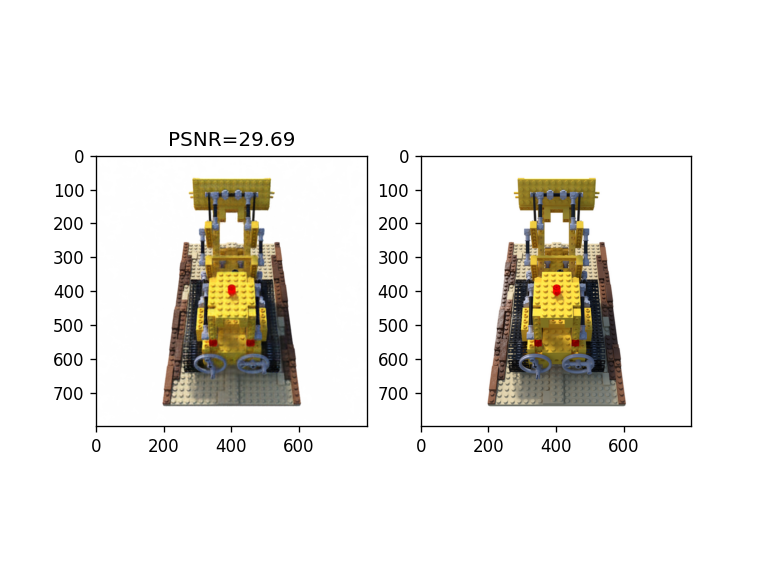

<IPython.core.display.Javascript object>


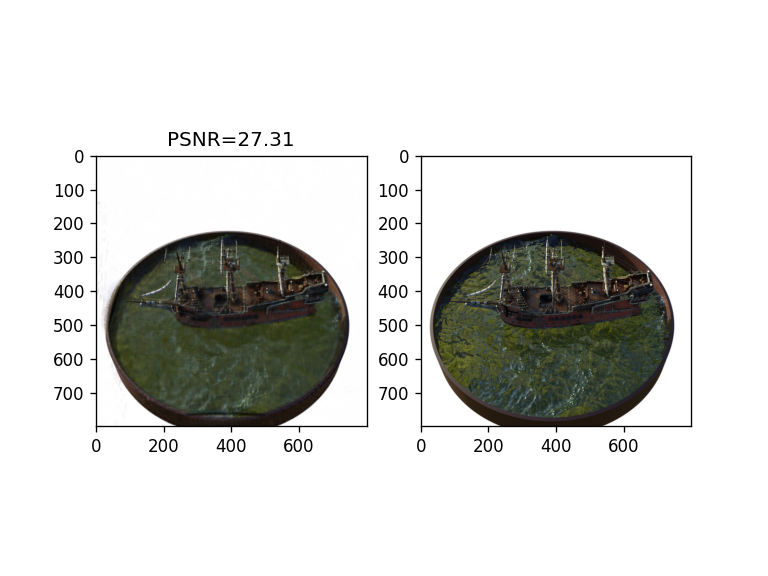

<IPython.core.display.Javascript object>


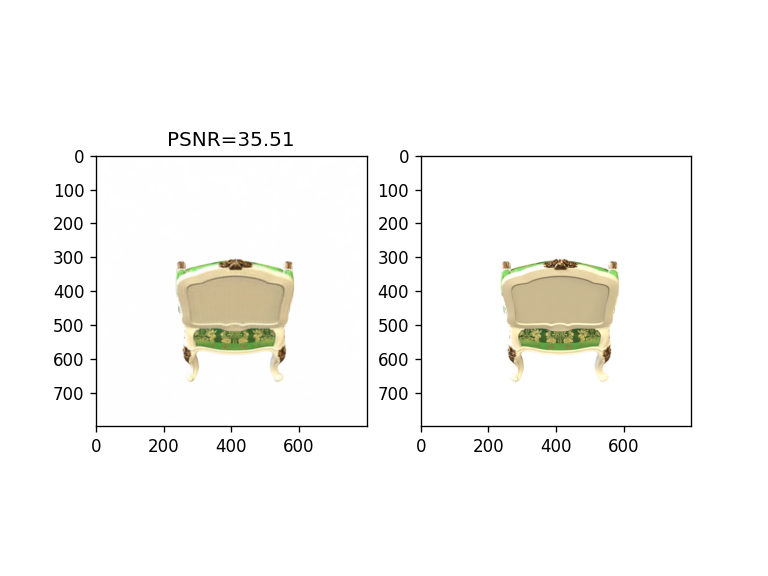

<IPython.core.display.Javascript object>


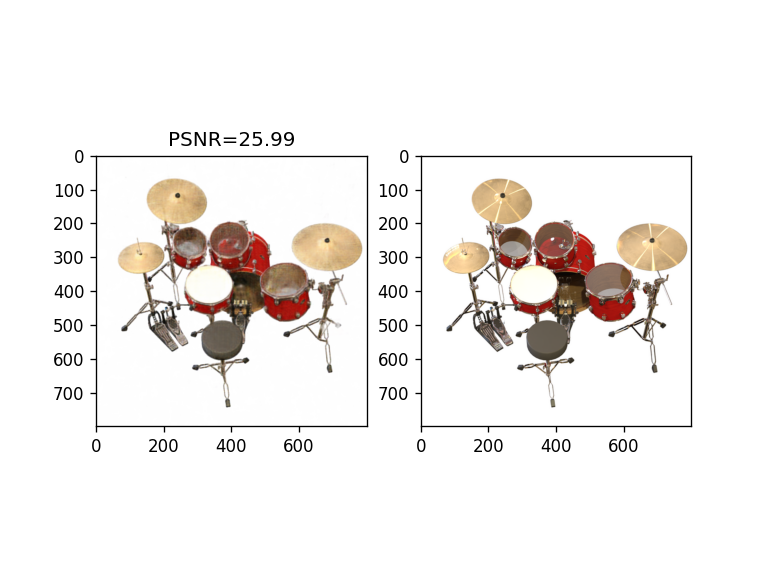

<IPython.core.display.Javascript object>


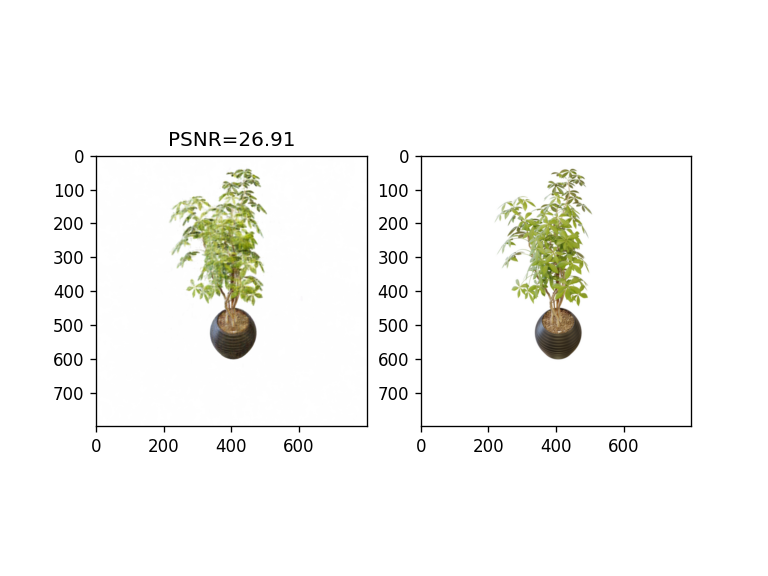

In [18]:
for i, dset in enumerate(ts_dsets):
    plot_ts(dset, plot_wrap(renderer, i), use_ext=True, batch_size=2_000)

#### Visualizing patches

In [19]:
import scipy.spatial
from tc_plenoxel import get_intersections, normalize_coord, sigma2alpha
import tc_plenoxel

In [20]:
def get_rays2(rot_angles, img_size, orig):
    focal = img_size  # This is slightly random
    rot = scipy.spatial.transform.Rotation.from_euler('ZYX', rot_angles, degrees=True)
    rot_mat = rot.as_matrix()
    orig = rot.apply(orig)  # This is random
    i, j = np.meshgrid(np.arange(img_size, dtype=np.float32) + 0.5, 
                       np.arange(img_size, dtype=np.float32) + 0.5, 
                       indexing='xy')
    dirs = np.stack([(i-img_size * .5)/focal, -(j-img_size * .5)/focal, -np.ones_like(i)], -1)
    rays_d = np.sum(dirs[..., np.newaxis, :] * rot_mat, -1)  
    rays_o = np.broadcast_to(orig, np.shape(rays_d))
    return rays_o.reshape(-1, 3), rays_d.reshape(-1, 3)
def interp(grid, pts):
    # grid [1, ch, res, res, res]
    # pts  [1, n, 1, 1, 3]
    interp_data = F.grid_sample(
        grid, pts, mode='bilinear', align_corners=True, padding_mode='zeros')  # [1, ch, n, 1, 1]
    interp_data = interp_data.squeeze()  # [ch, n] or [n] if ch is 1
    return interp_data
def get_intersections(rays_o: torch.Tensor,
                      rays_d: torch.Tensor,
                      aabb: torch.Tensor,
                      step_size: float,
                      n_samples: int) -> torch.Tensor:
    dev, dt = rays_o.device, rays_o.dtype
    offsets_pos = (aabb[1] - rays_o) / rays_d  # [batch, 3]
    offsets_neg = (aabb[0] - rays_o) / rays_d  # [batch, 3]
    offsets_in = torch.minimum(offsets_pos, offsets_neg)  # [batch, 3]
    start = torch.amax(offsets_in, dim=-1, keepdim=True)  # [batch, 1]
    steps = torch.arange(n_samples, dtype=dt, device=dev).unsqueeze(0)  # [1, n_intrs]
    steps = steps.repeat(rays_d.shape[0], 1)   # [batch, n_intrs]
    intersections = start + steps * step_size  # [batch, n_intrs]
    return intersections
def render(aabb, voxel_len, sh_encoder, n_samples, angle, orig, img_size, patch):
    aabb_size = aabb[1] - aabb[0]
    inv_aabb_size = 2 / aabb_size
    rays_o, rays_d = get_rays2(angle, img_size, orig)
    rays_o = torch.from_numpy(rays_o).view(-1, 3).float()
    rays_d = torch.from_numpy(rays_d).view(-1, 3).float()
    intersections = get_intersections(
        rays_o=rays_o, rays_d=rays_d, aabb=aabb, step_size=voxel_len,
        n_samples=n_samples)
    intersections_trunc = intersections[:, :-1]
    intrs_pts = rays_o.unsqueeze(1) + intersections_trunc.unsqueeze(2) * rays_d.unsqueeze(1)
    intrs_pts = normalize_coord(intrs_pts, aabb, inv_aabb_size).flip(-1)
    data_interp = interp(
        grid=patch.unsqueeze(0),
        pts = intrs_pts.view(1, -1, 1, 1, 3)
    ).transpose(0, 1)
    sigma = data_interp[:, -1].view(intersections_trunc.shape)
    cdata = data_interp[:, :-1].view(*intersections_trunc.shape, -1)

    sigma = F.relu(sigma)
    alpha, abs_light = sigma2alpha(sigma, intersections, rays_d)
    sh_mult = sh_encoder(rays_d)  # batch, ch/3
    sh_mult = sh_mult.unsqueeze(1).unsqueeze(1).expand(-1, cdata.shape[1], -1, -1)
    cdata = cdata.view(cdata.shape[0], cdata.shape[1], 3, sh_mult.shape[-1])

    rgb = torch.sum(sh_mult * cdata, dim=-1)
    rgb = tc_plenoxel.shrgb2rgb(rgb, abs_light, True)
    return rgb

In [21]:
patches = renderer.atoms.detach().cpu()
patches.size()

torch.Size([64, 13, 5, 5, 5])

In [22]:
aabb = torch.tensor([[-0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])
orig = np.array([0, 0, 3], dtype=np.float32)
n_samples = 40
voxel_len = math.sqrt(3) / n_samples
sh_encoder = tc_plenoxel.plenoxel_sh_encoder(1)

In [23]:
angles = np.zeros((12, 3))
angles[:, 0] = np.arange(0, 360, 30)
angles[:, 1] = 10
angles[:, 2] = 180

<IPython.core.display.Javascript object>


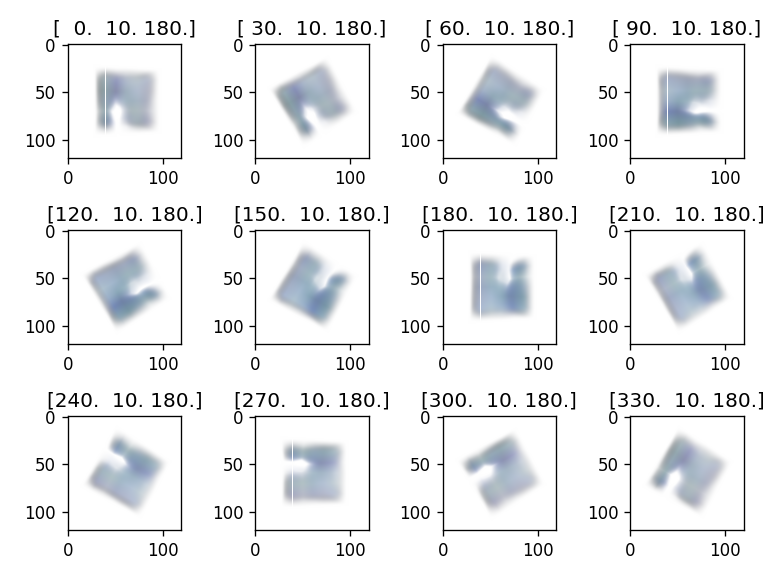

In [504]:
fig, ax = plt.subplots(nrows=3, ncols=4)
ax = ax.flatten()
for i, angle in enumerate(angles):
    rgb = render(aabb, voxel_len, sh_encoder, n_samples, angle, orig, 60, patch=patches[3])
    ax[i].imshow(rgb.view(int(math.sqrt(rgb.shape[0])), int(math.sqrt(rgb.shape[0])), 3))
    ax[i].set_title("%s" % (angle, ))
fig.tight_layout()

<IPython.core.display.Javascript object>


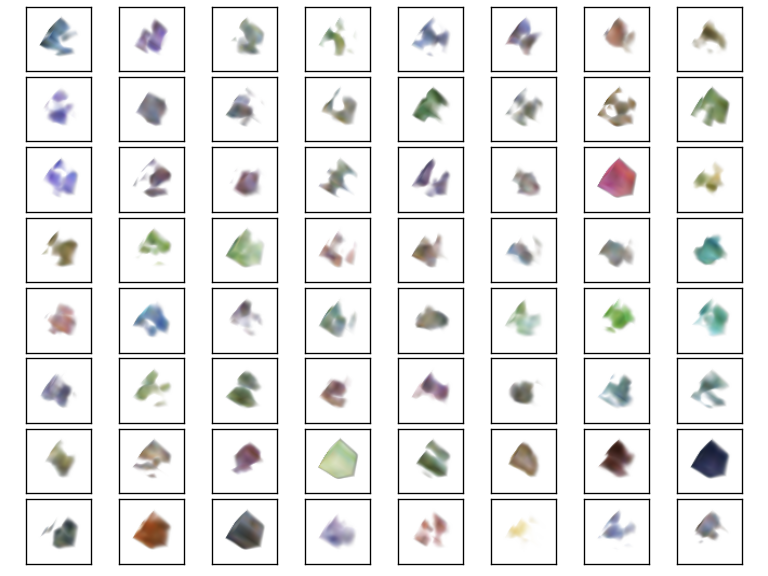

<ipython-input-20-84949b495c42>:38: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  rays_o = torch.from_numpy(rays_o).view(-1, 3).float()


In [24]:
fig, ax = plt.subplots(nrows=8, ncols=8)
ax = ax.flatten()
angle = (60, 230, 60)
for i in range(64):#patches.shape[0]:
    rgb = render(aabb, voxel_len, sh_encoder, n_samples, angle, orig, 60, patch=patches[i])
    ax[i].imshow(rgb.view(int(math.sqrt(rgb.shape[0])), int(math.sqrt(rgb.shape[0])), 3))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.tight_layout(pad=0.4, h_pad=0.0, w_pad=0.0)

<IPython.core.display.Javascript object>


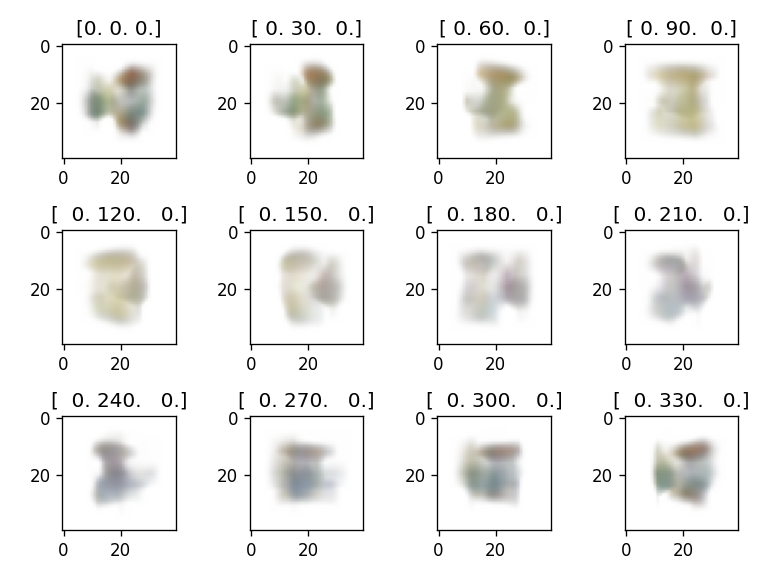

In [437]:
fig, ax = plt.subplots(nrows=3, ncols=4)
ax = ax.flatten()
for i, angle in enumerate(angles):
    rgb = render(angle, 40, patch=patches[50])
    ax[i].imshow(rgb.view(int(math.sqrt(rgb.shape[0])), int(math.sqrt(rgb.shape[0])), 3))
    ax[i].set_title("%s" % (angle, ))
fig.tight_layout()